# This is Lab 4 executable file

This file contains the program code that is the solution to the tasks from the file [lab_4_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_4/lab_4_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [29]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from scipy import signal
from datetime import datetime
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

from prettytable import PrettyTable

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

from sklearn.metrics import mean_absolute_error

from itertools import product
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta


## Exercise №1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [2]:
# Load dataset
path_to_file = '../Datasets/timeStamped_Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head(10)

# Aggregation

# Proccess Timestamps
source_df['timeStamp']=pd.to_datetime(source_df['timeStamp'], format='%Y-%m-%d %H:%M:%S')
source_df['timeStamp']=source_df['timeStamp'].dt.round('3h') 

# Choose varioables
# target:
target_cols = ["blueTotalHeal", "blueTotalGold"]
# predictors:
pred_cols = ["gameDuraton", "blueChampionDamageDealt"]

col_names = target_cols + pred_cols

df_agged=source_df.groupby('timeStamp', as_index=False).agg({"blueTotalHeal": "mean", "blueTotalGold": "mean", "gameDuraton": "mean", "blueChampionDamageDealt": "mean"})
df_agged=df_agged.sort_values('timeStamp')
df_agged.head(10)

timeStamp  blueTotalHeal  blueTotalGold  gameDuraton  \
0 2019-01-03 18:00:00      18.092000      43.865000    23.900000   
1 2019-01-05 18:00:00      35.028667      51.676000    26.477778   
2 2019-01-07 18:00:00      20.913333      46.317333    22.594444   
3 2019-01-08 15:00:00      21.567000      60.554000    26.416667   
4 2019-01-08 18:00:00      45.280000      78.178000    37.250000   
5 2019-01-11 18:00:00      24.877500      48.762000    24.225000   
6 2019-01-12 18:00:00      31.983000      70.050000    31.500000   
7 2019-01-13 15:00:00       5.726000      40.619000    23.233333   
8 2019-01-14 12:00:00      16.576000      33.484000    15.333333   
9 2019-01-14 15:00:00      29.339000      52.979000    27.550000   

   blueChampionDamageDealt  
0                57.547000  
1                72.211333  
2                51.522333  
3                94.014000  
4               114.909000  
5                60.525500  
6               110.272000  
7                54.175000  
8                26.938000  
9                80.685000

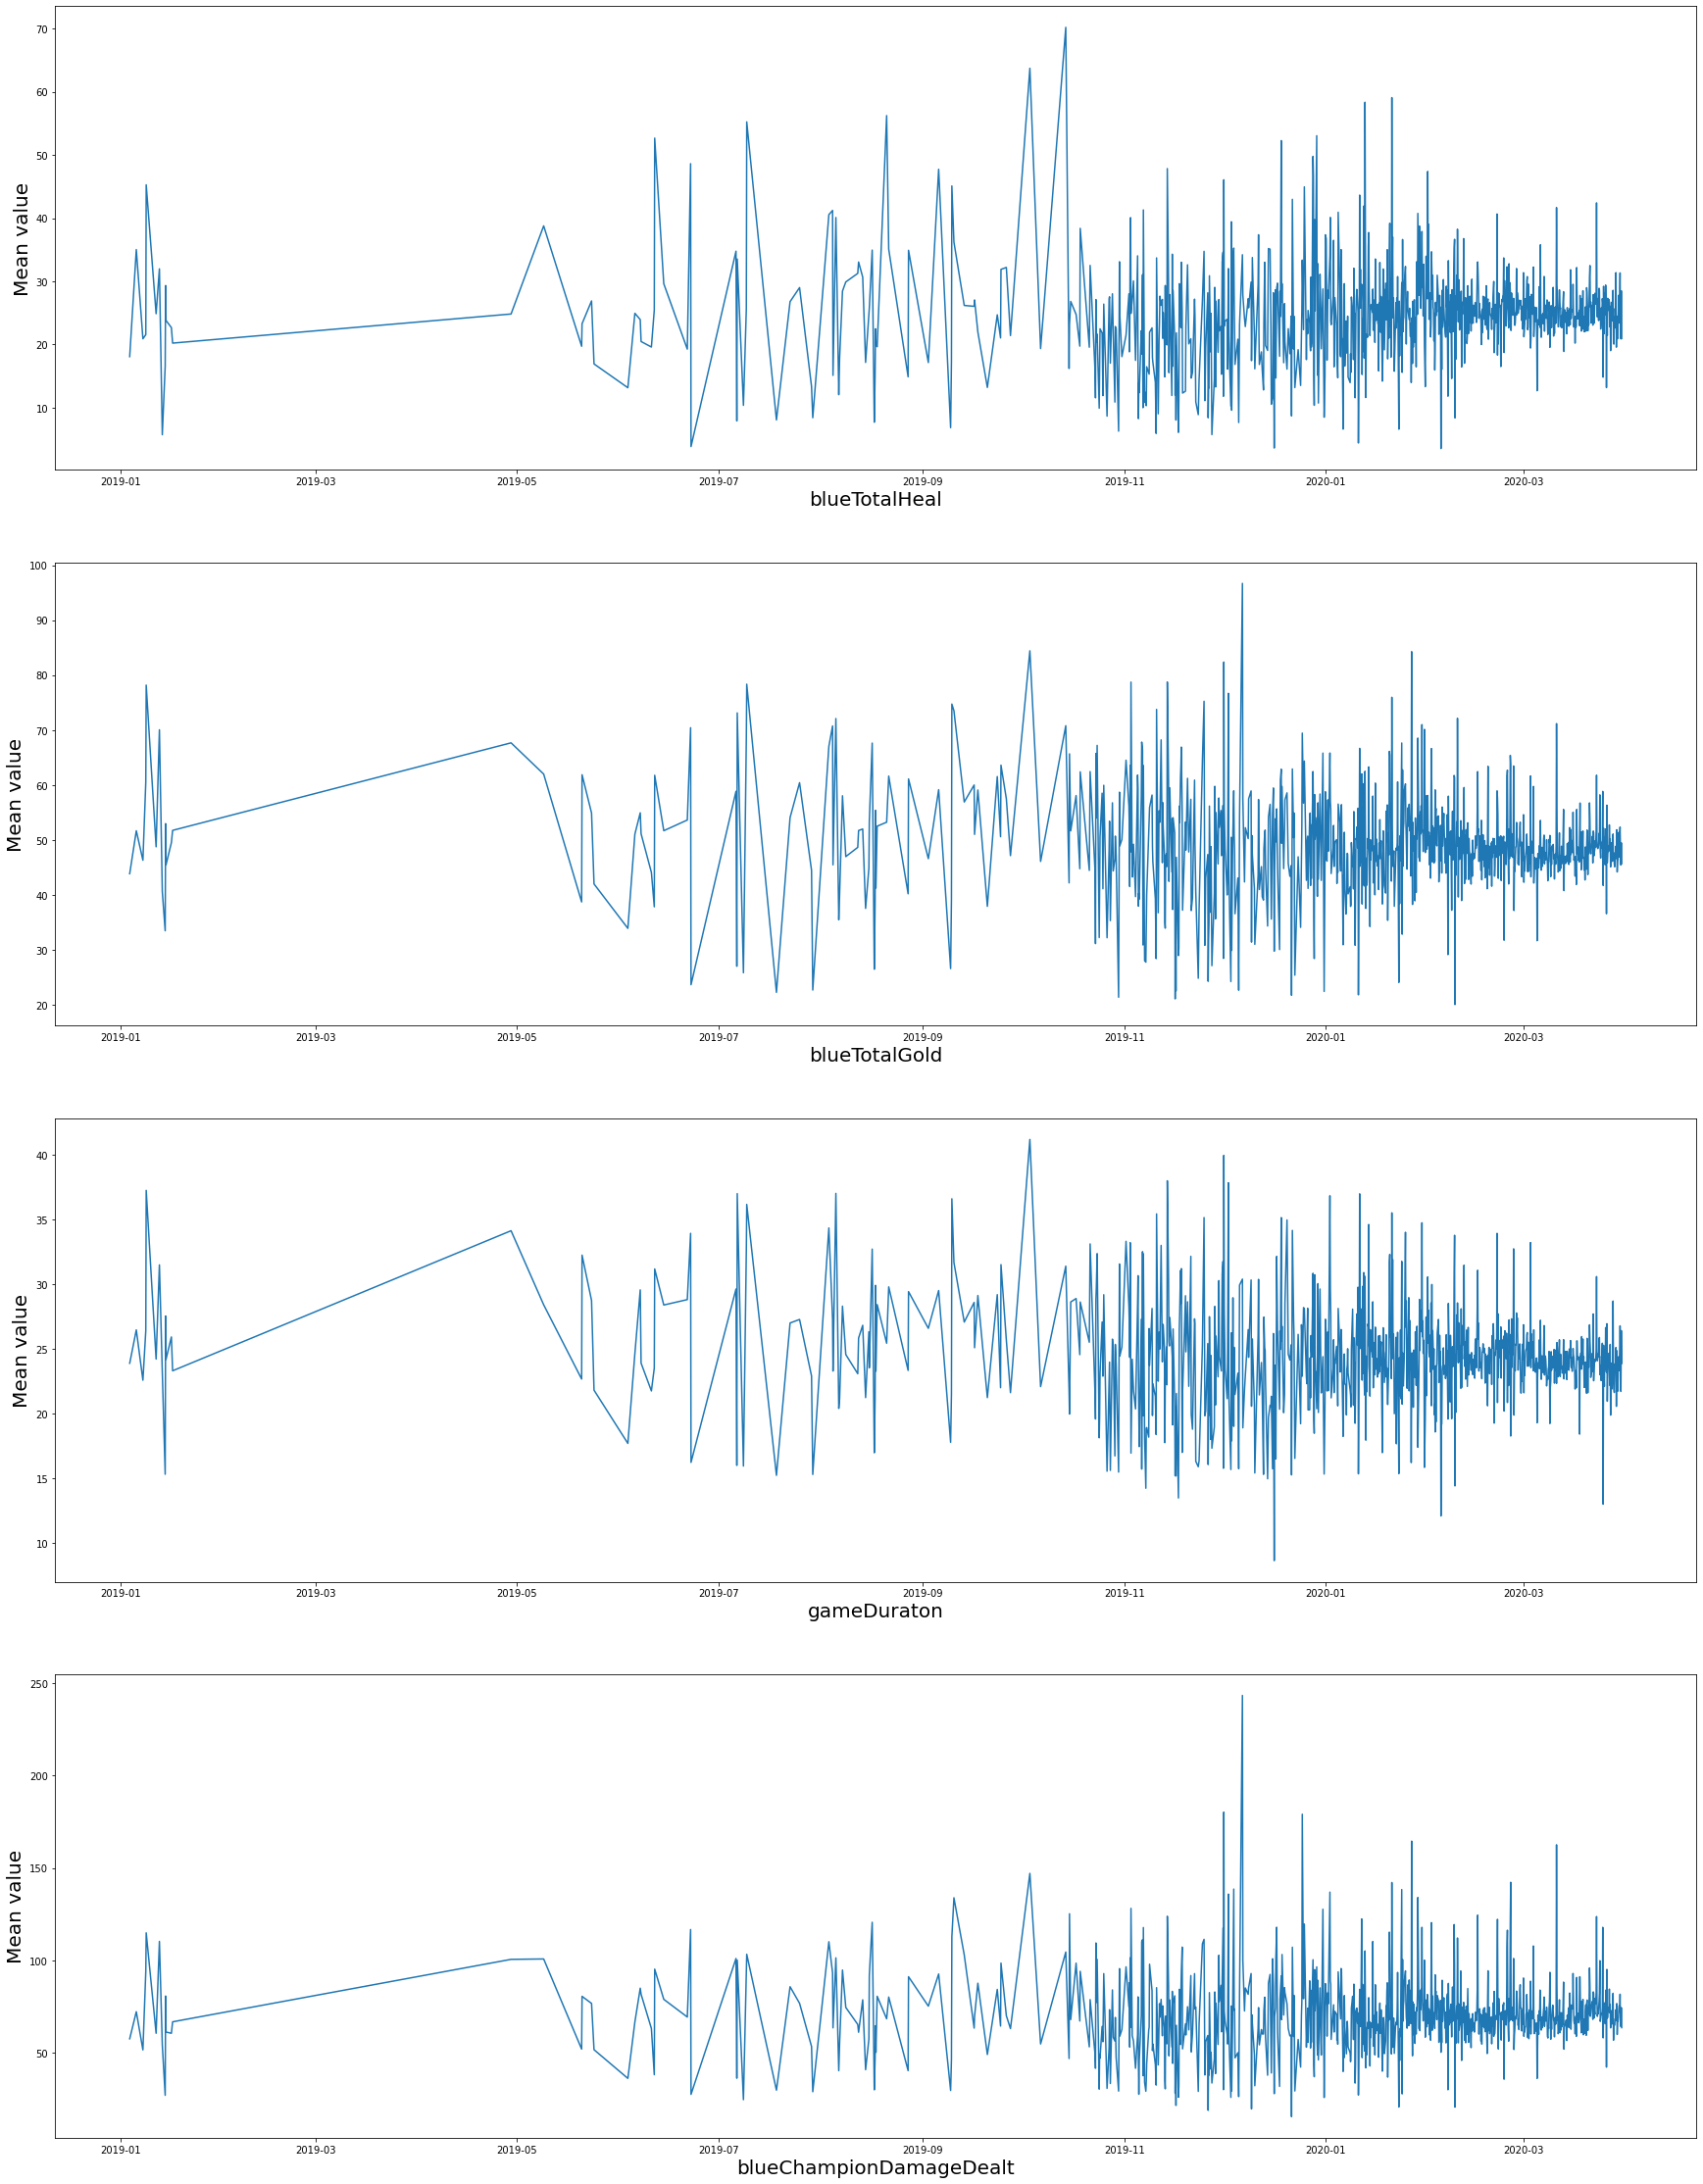

In [3]:

# Show processes for all data
fig, axes = plt.subplots(len(col_names), figsize=(30, 10 * len(col_names)))

idx = 0
for col_name in col_names:
    axes[idx].plot(df_agged['timeStamp'],df_agged[col_name])

    axes[idx].set_xlabel(col_name, fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)

    idx += 1


## Exercise №2

Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

696


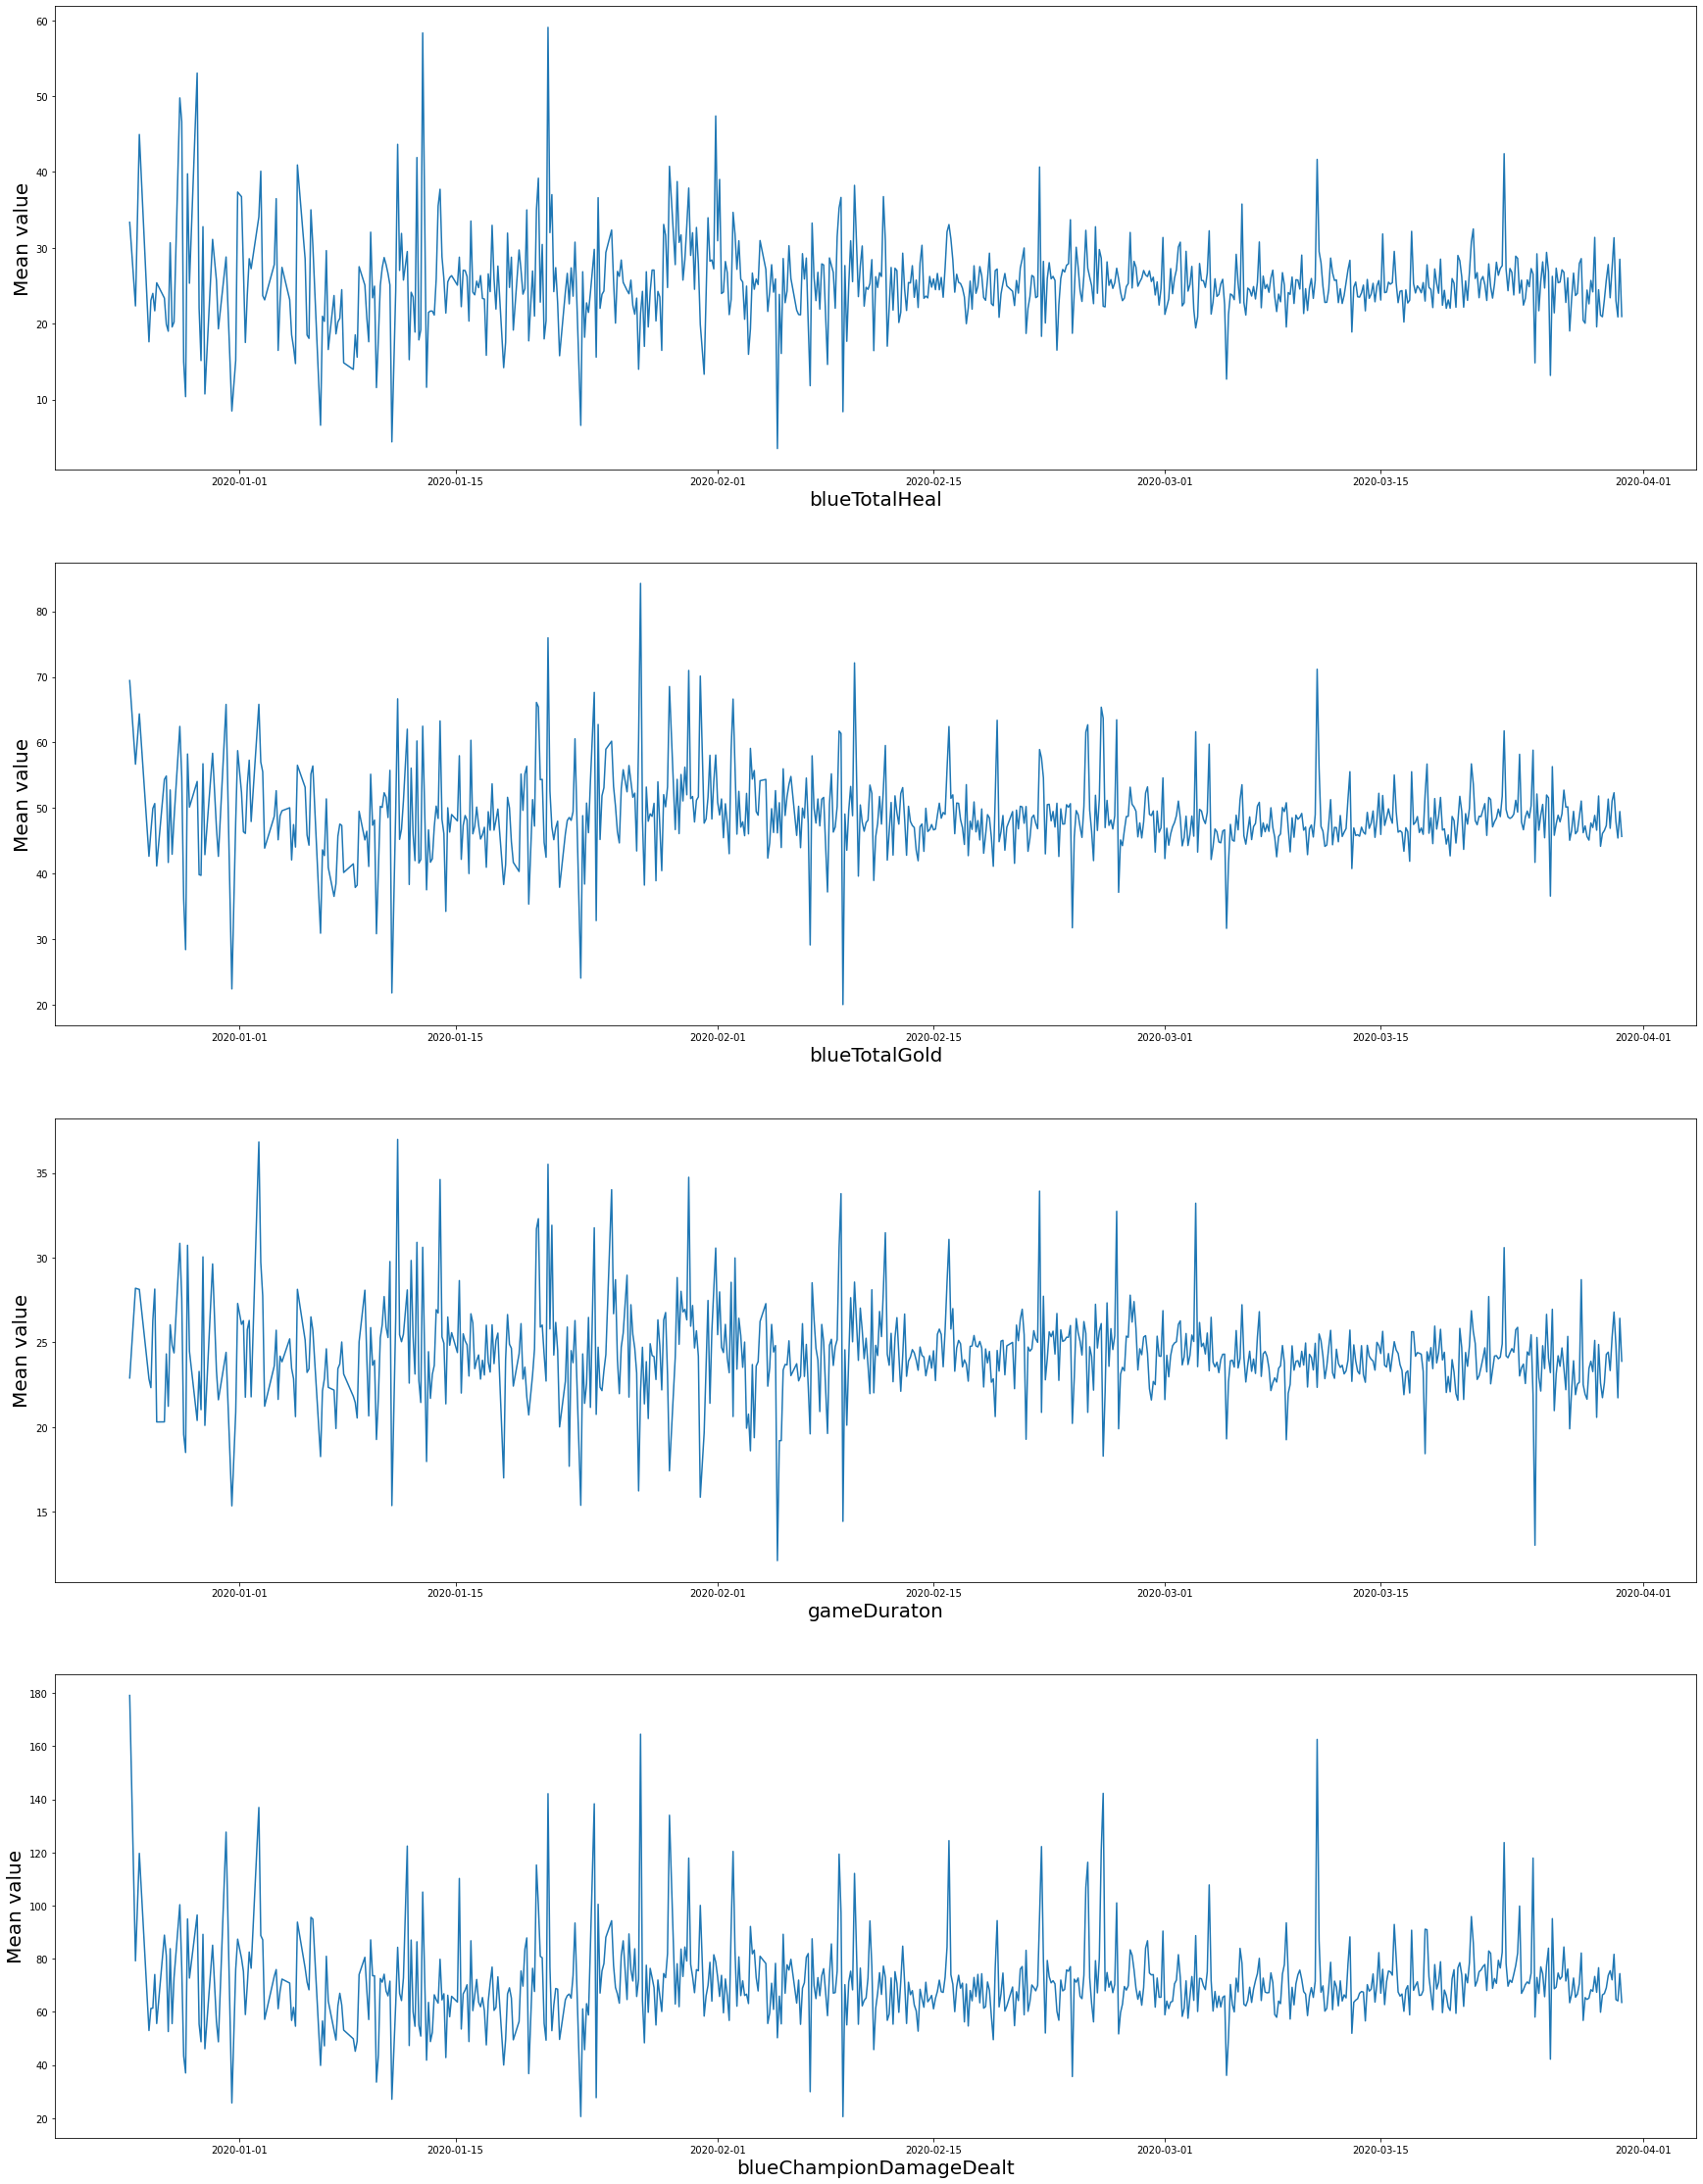

In [4]:
# Make proccess more Stationary
# Remove first sparce part from aggregeted data
drop_part = 300
df_stat = df_agged.drop(df_agged.head(drop_part).index, inplace=False)
print(len(df_stat))
fig, axes = plt.subplots(len(col_names), figsize=(30, 10 * len(col_names)))

idx = 0
for col_name in col_names:
    axes[idx].plot(df_stat['timeStamp'],df_stat[col_name])

    axes[idx].set_xlabel(col_name, fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)

    idx += 1

In [5]:
# Test for Stationarity
table = PrettyTable()
table.field_names = ["column name", "statistic value", "p-value", "stat/non-stat"]
for col_name in col_names:
    result = smt.stattools.adfuller(df_stat[col_name], regression="ct")
    # print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))
    sign_lvl = 0.05
    if result[1] < sign_lvl:
        table.add_row([col_name, result[0], result[1], "STATIONARY"])
    else:
        table.add_row([col_name, result[0], result[1], "NON-STATIONARY"])
print(table)

+-------------------------+---------------------+------------------------+---------------+
|       column name       |   statistic value   |        p-value         | stat/non-stat |
+-------------------------+---------------------+------------------------+---------------+
|      blueTotalHeal      | -7.8409336531706515 | 1.6662415874867163e-10 |   STATIONARY  |
|      blueTotalGold      |  -6.731542011878182 | 5.6679759422940115e-08 |   STATIONARY  |
|       gameDuraton       |  -8.429682382616507 | 7.280465385711972e-12  |   STATIONARY  |
| blueChampionDamageDealt |  -7.442436027619189 | 1.3822419845723706e-09 |   STATIONARY  |
+-------------------------+---------------------+------------------------+---------------+


## Exercise №3

Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

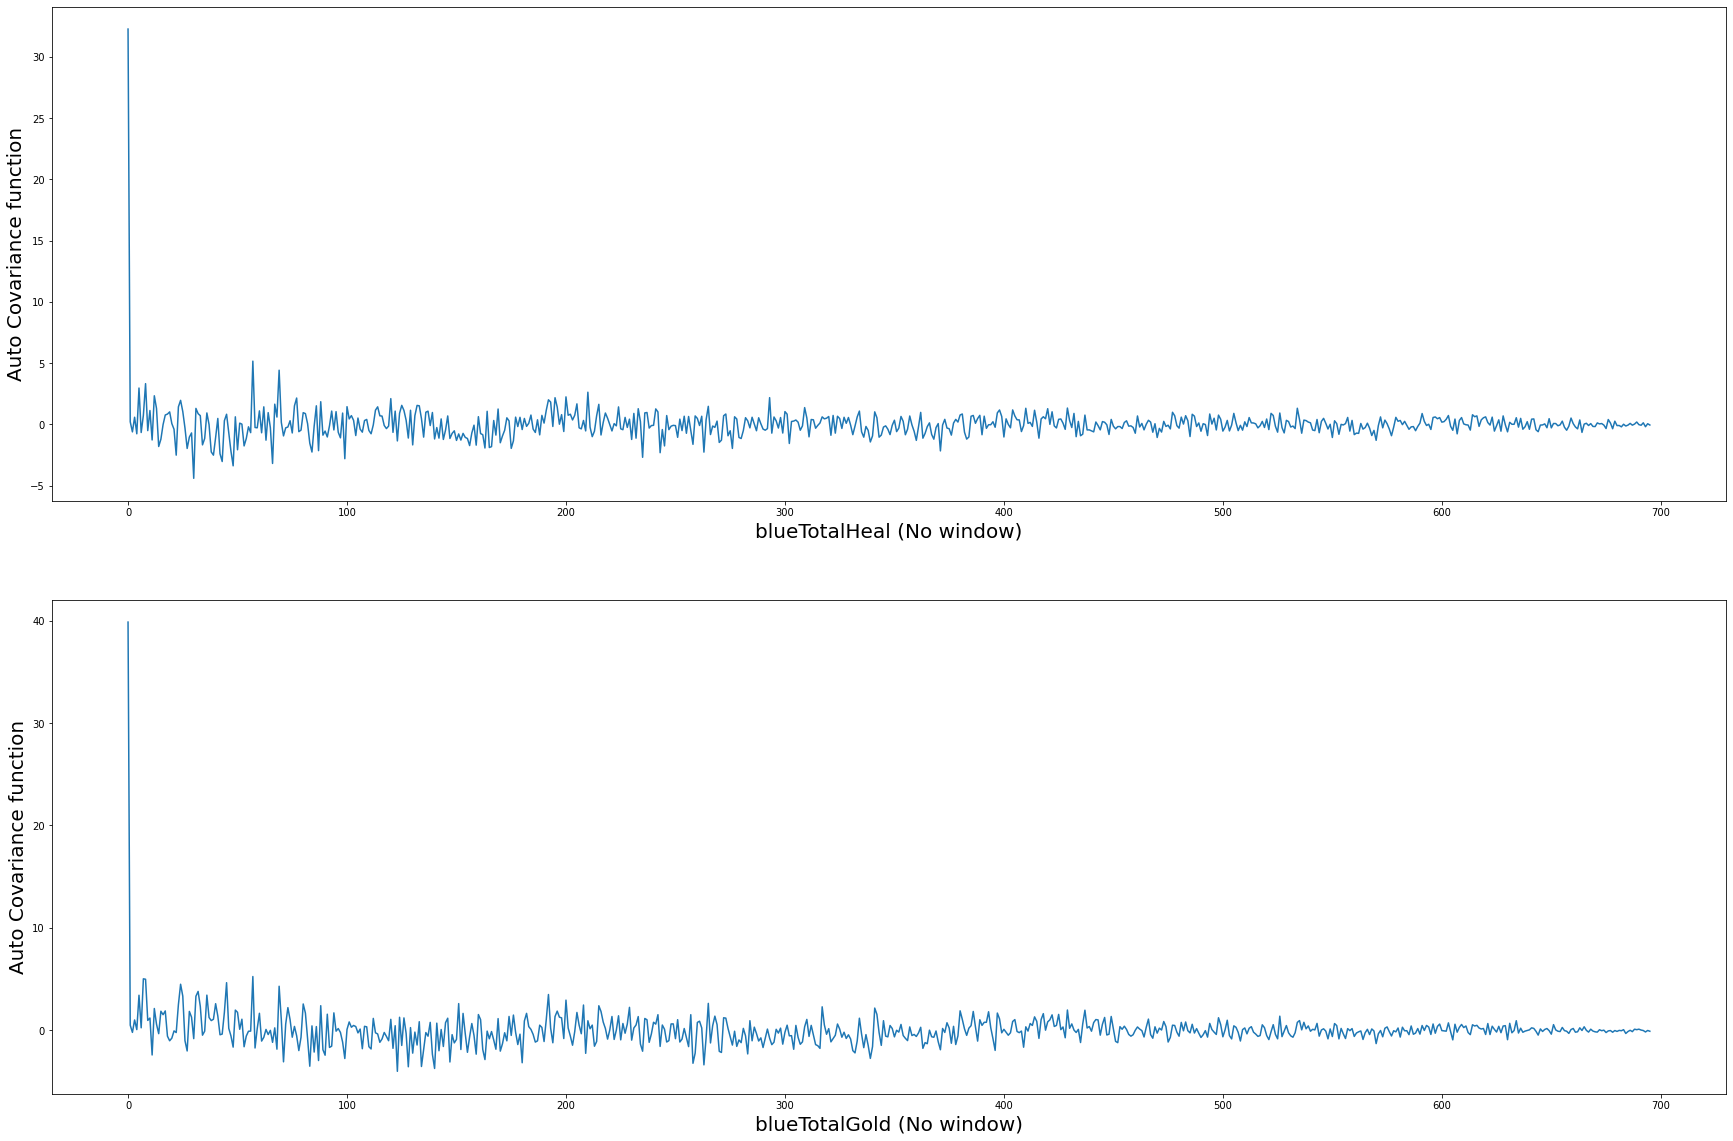

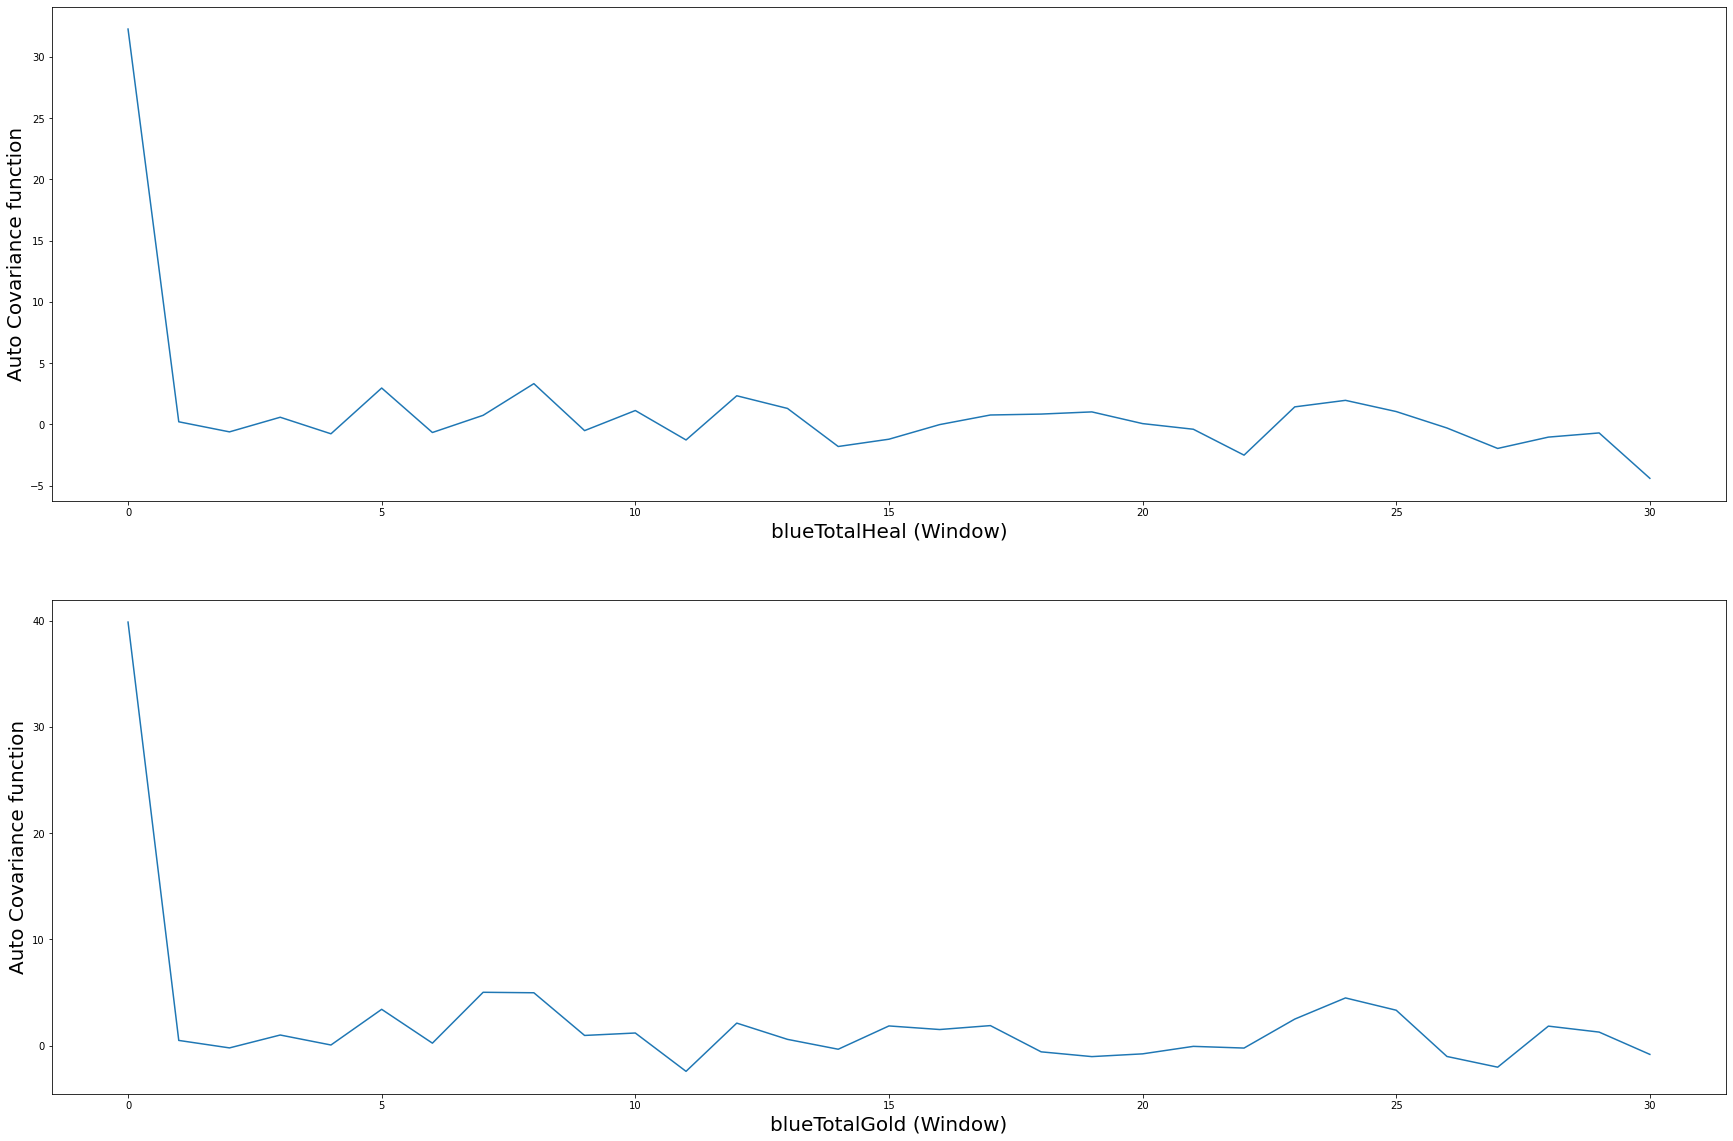

In [6]:
# Analyze auto covariance function (Seems like for stationary processes )

# Autocovariance without window
fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0
for col_name in target_cols:
    axes[idx].plot(stattools.acovf(df_stat[col_name],fft=False)) 
    axes[idx].set_xlabel(col_name+" (No window)", fontsize = 20)
    axes[idx].set_ylabel(u'Auto Covariance function', fontsize = 20)
    idx += 1

# Autocovariance with window
window_size=30
fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0
for col_name in target_cols:
    axes[idx].plot(stattools.acovf(df_stat[col_name], nlag=window_size, fft=False)) 
    axes[idx].set_xlabel(col_name+" (Window)", fontsize = 20)
    axes[idx].set_ylabel(u'Auto Covariance function', fontsize = 20)
    idx += 1

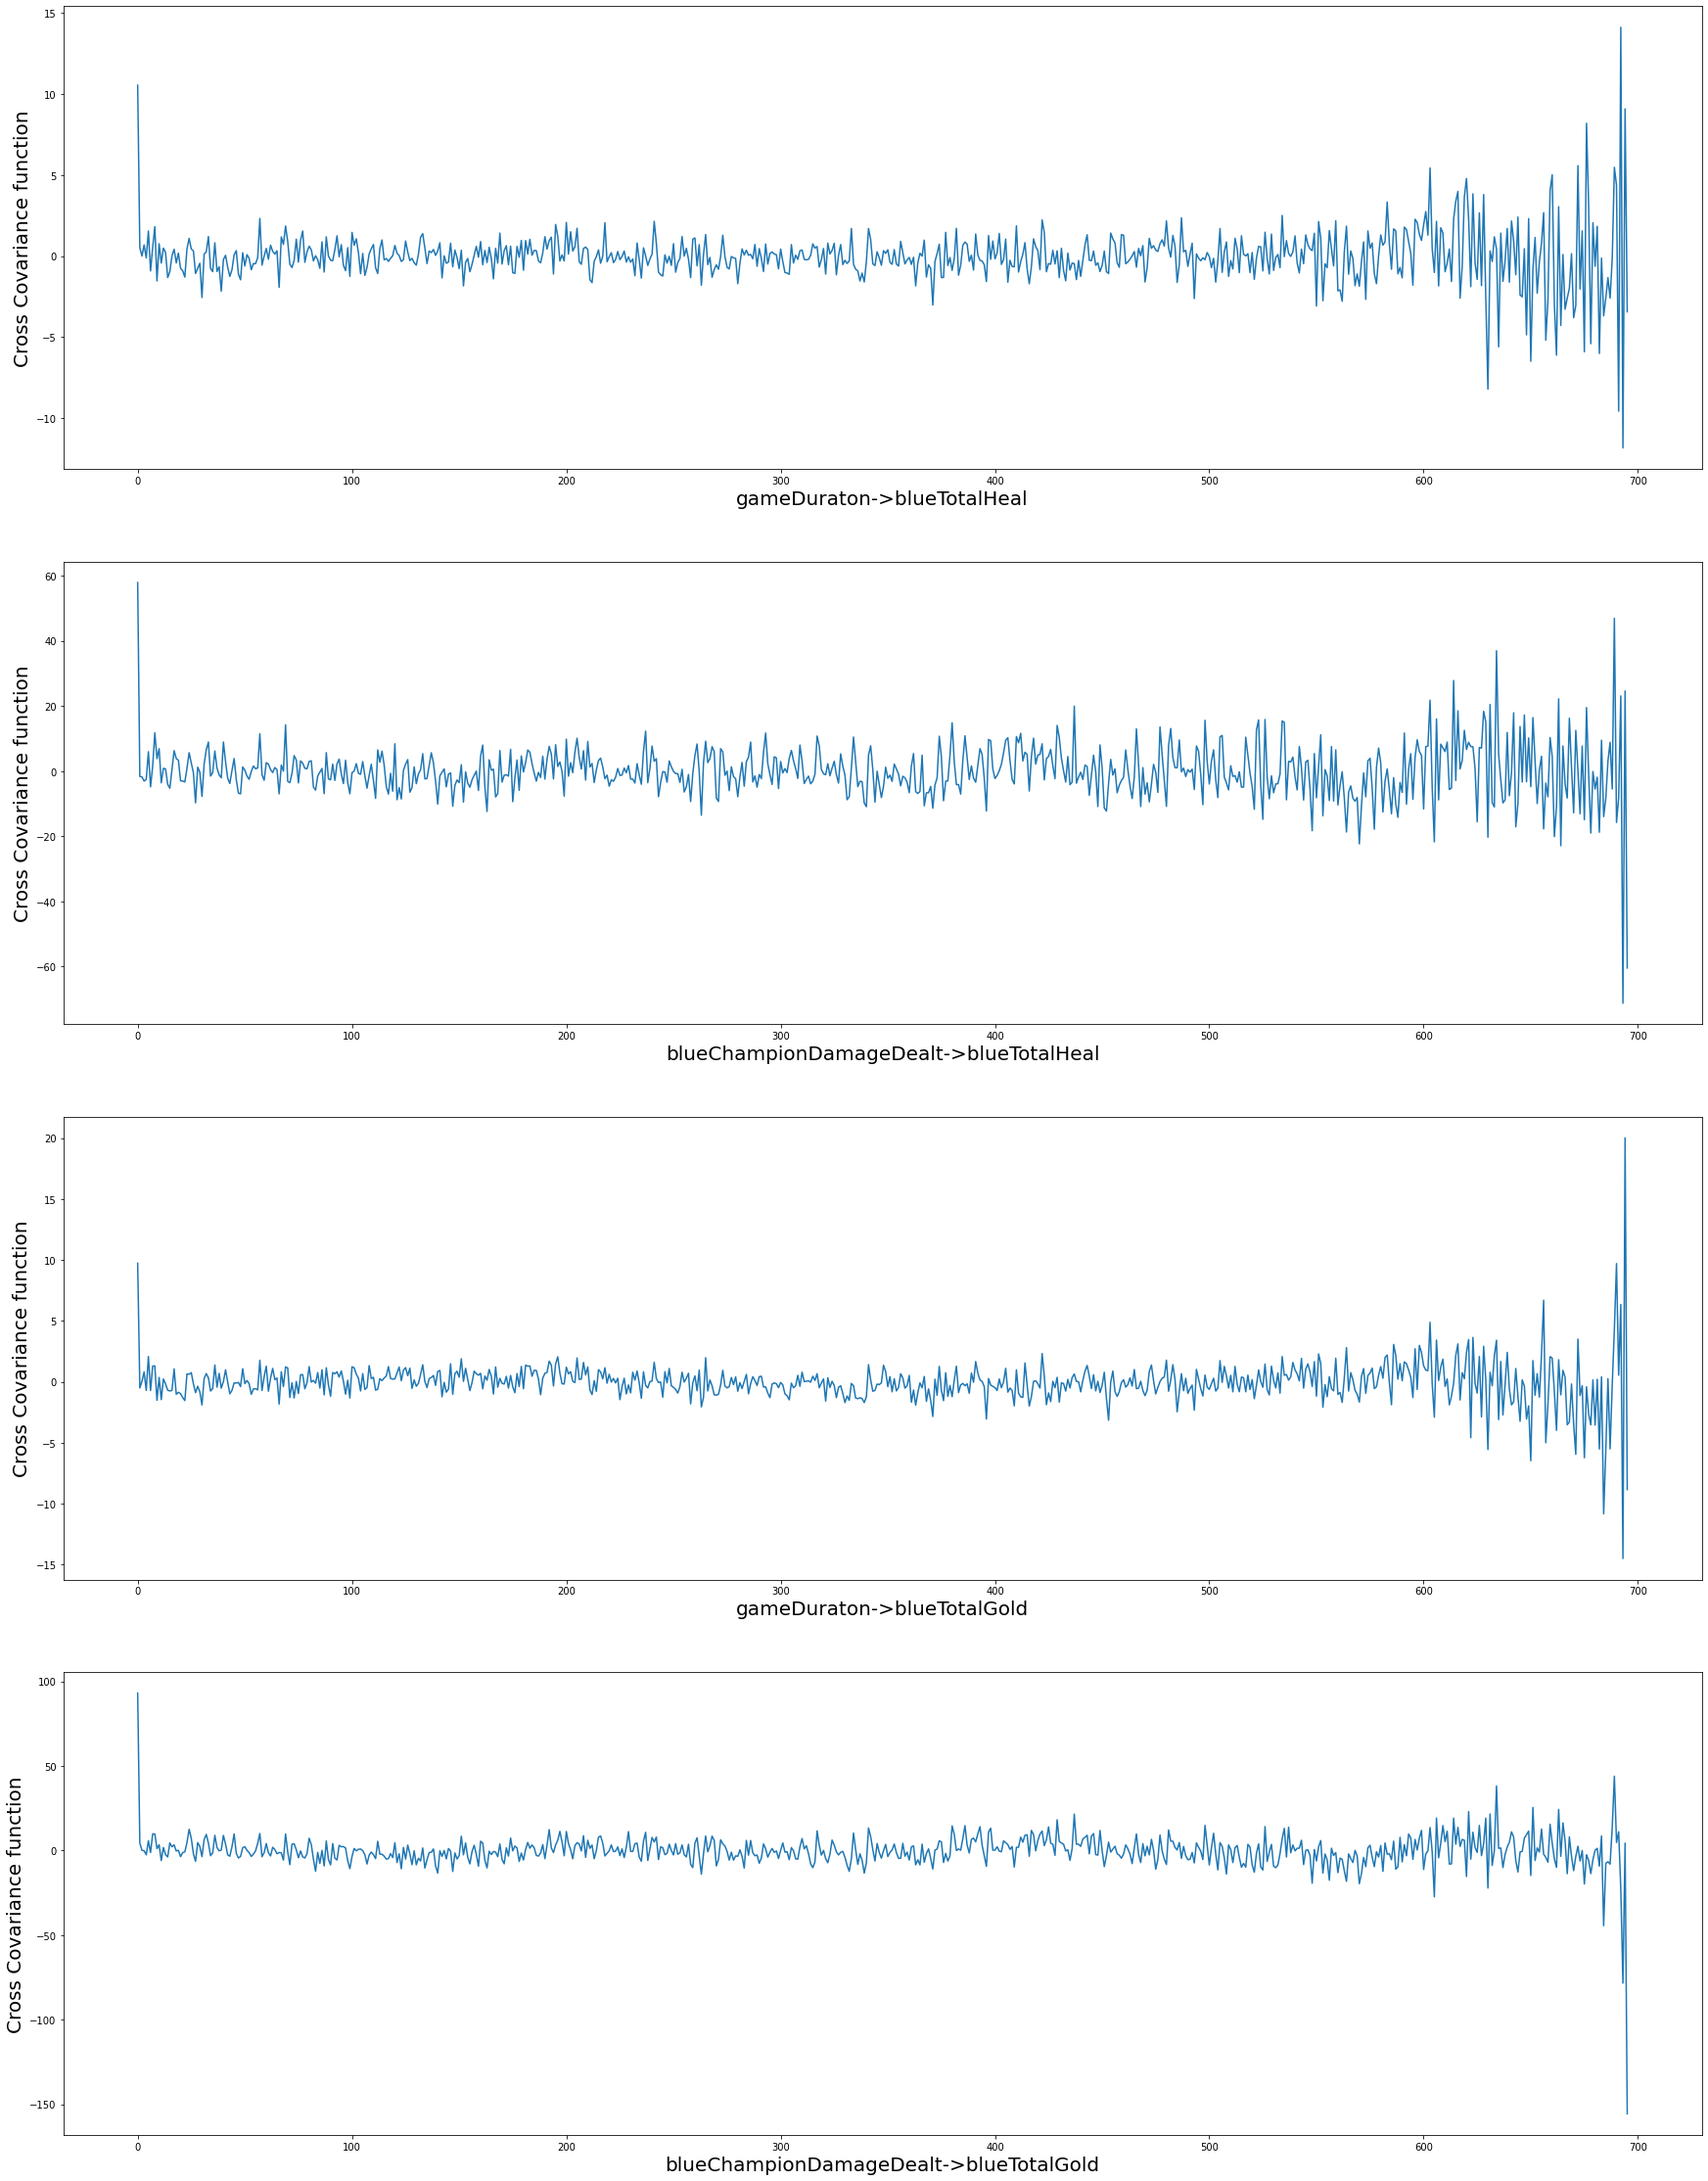

In [7]:
# Analize the cross-covariance between predictor->target 

fig, axes = plt.subplots(len(target_cols)*len(pred_cols), figsize=(30, 10 * len(target_cols) * len(pred_cols)))
idx = 0

for targ_name in target_cols:
    for pred_name in pred_cols:

        axes[idx].plot(stattools.ccovf(x = df_stat[pred_name], y = df_stat[targ_name], fft=False)) 
        axes[idx].set_xlabel(pred_name+'->'+targ_name, fontsize = 20)
        axes[idx].set_ylabel(u'Cross Covariance function', fontsize = 20)
        idx += 1


<AxesSubplot:>

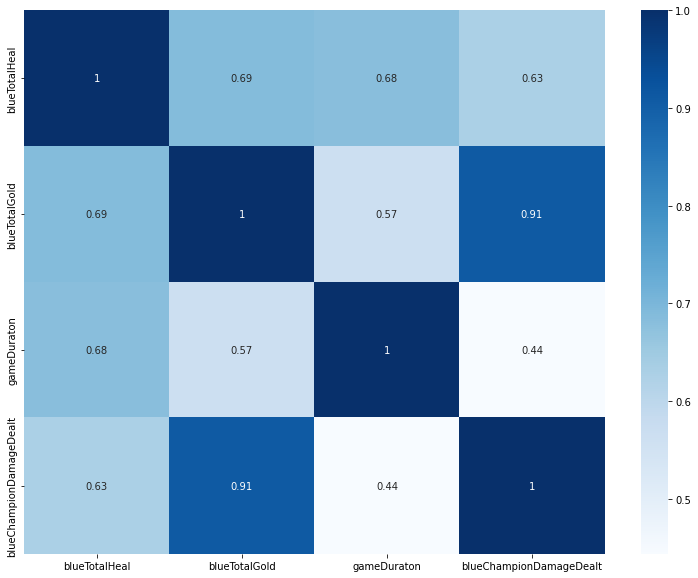

In [8]:
# Show Cross correlation matrix

# Correlation coefficients
fig, axes = plt.subplots(1, 1, figsize=(13, 10))
sns.heatmap(df_stat.corr(), cmap='Blues', annot=True)

## Exercise №4

Filter high frequencies (noise) with chosen 2 filters for target variables

In [9]:
# Prepare data for FEDOT

input_data_list = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))

# Convert into numpy array first
for targ_name in target_cols:
    time_series = np.array(df_stat[targ_name])
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)

    input_data_list.append(input_data)

    

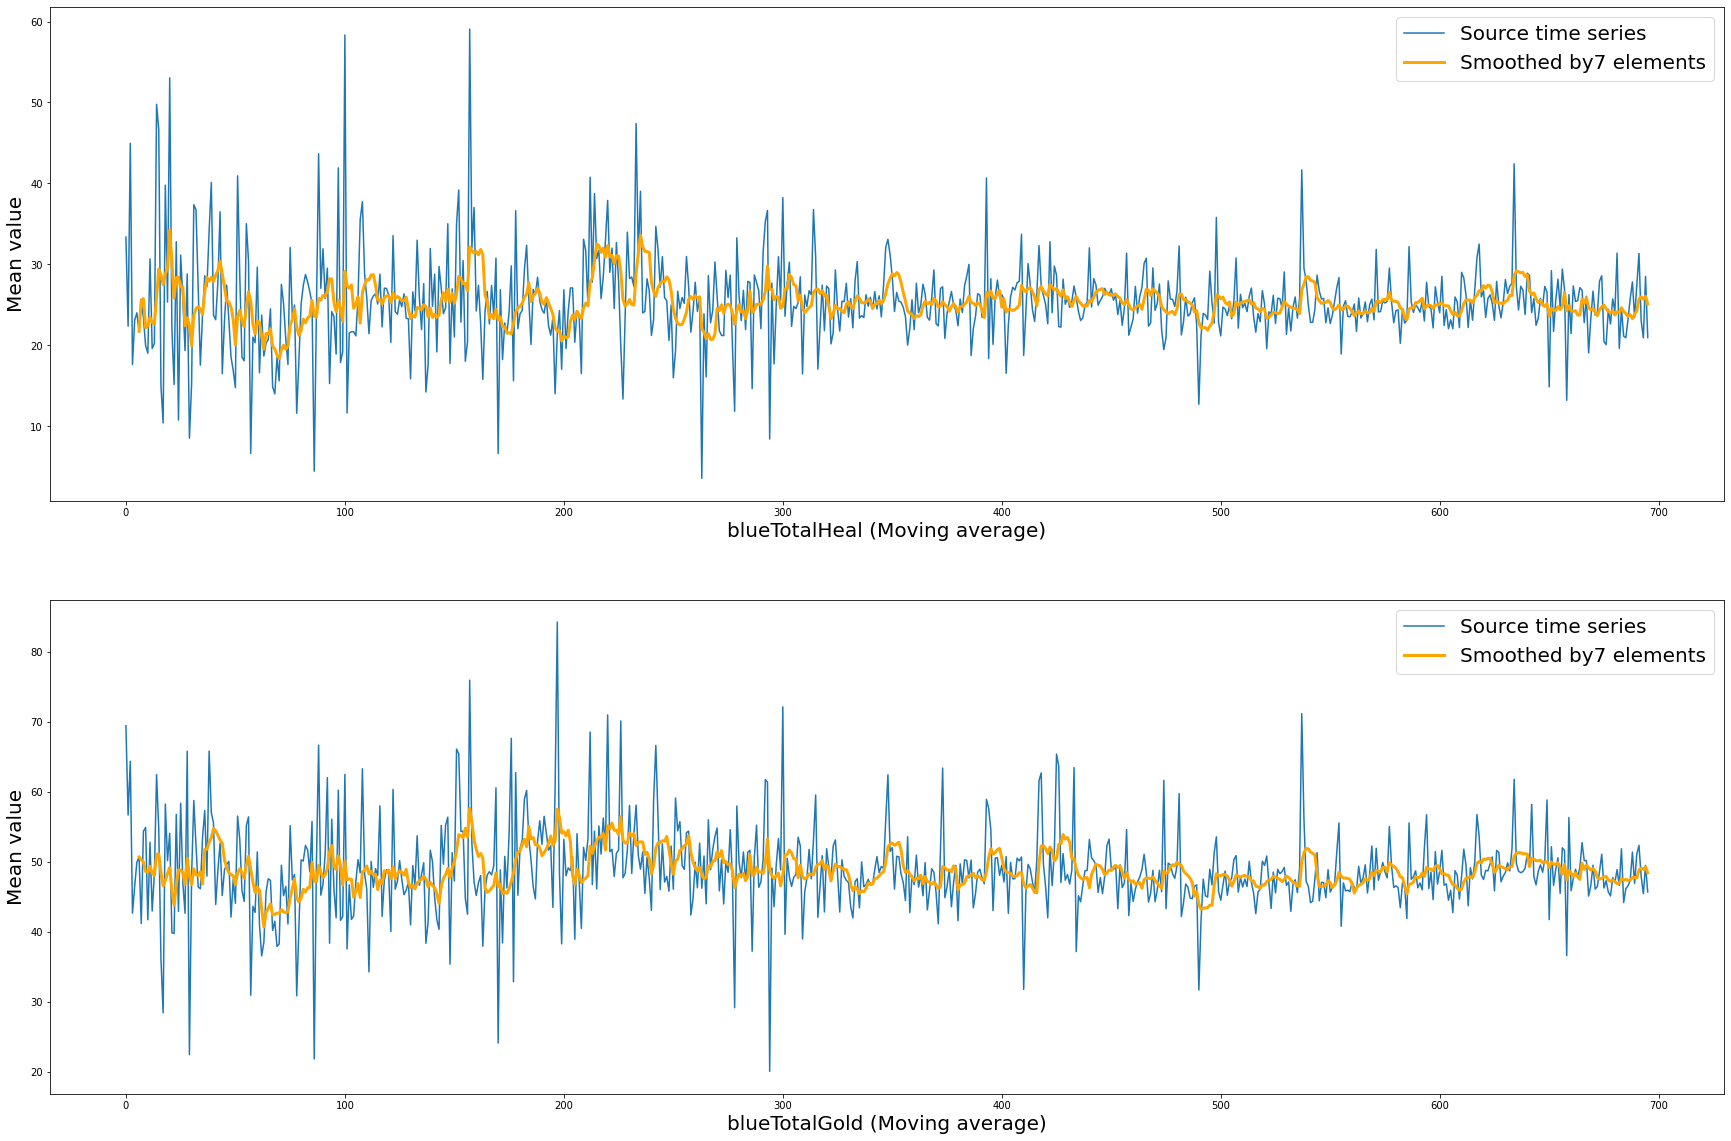

In [10]:
# Moving average filter 

window_size = 7

smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': window_size}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

roll_filt_targs = []

fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0

for col_name in target_cols:
    smoothed_output = node_fit_predict(smoothing_node, input_data_list[idx])
    roll_filt_targs.append(smoothed_output.predict[window_size-1:]) # Cut First elements, that coinside with pure data (input)

    axes[idx].plot(input_data_list[idx].idx, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(smoothed_output.idx[window_size-1:], smoothed_output.predict[window_size-1:], label='Smoothed by'+str(window_size)+' elements', c="orange", linewidth=3)
    axes[idx].set_xlabel(col_name+" (Moving average)", fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)
    axes[idx].legend(fontsize=20)
    idx += 1


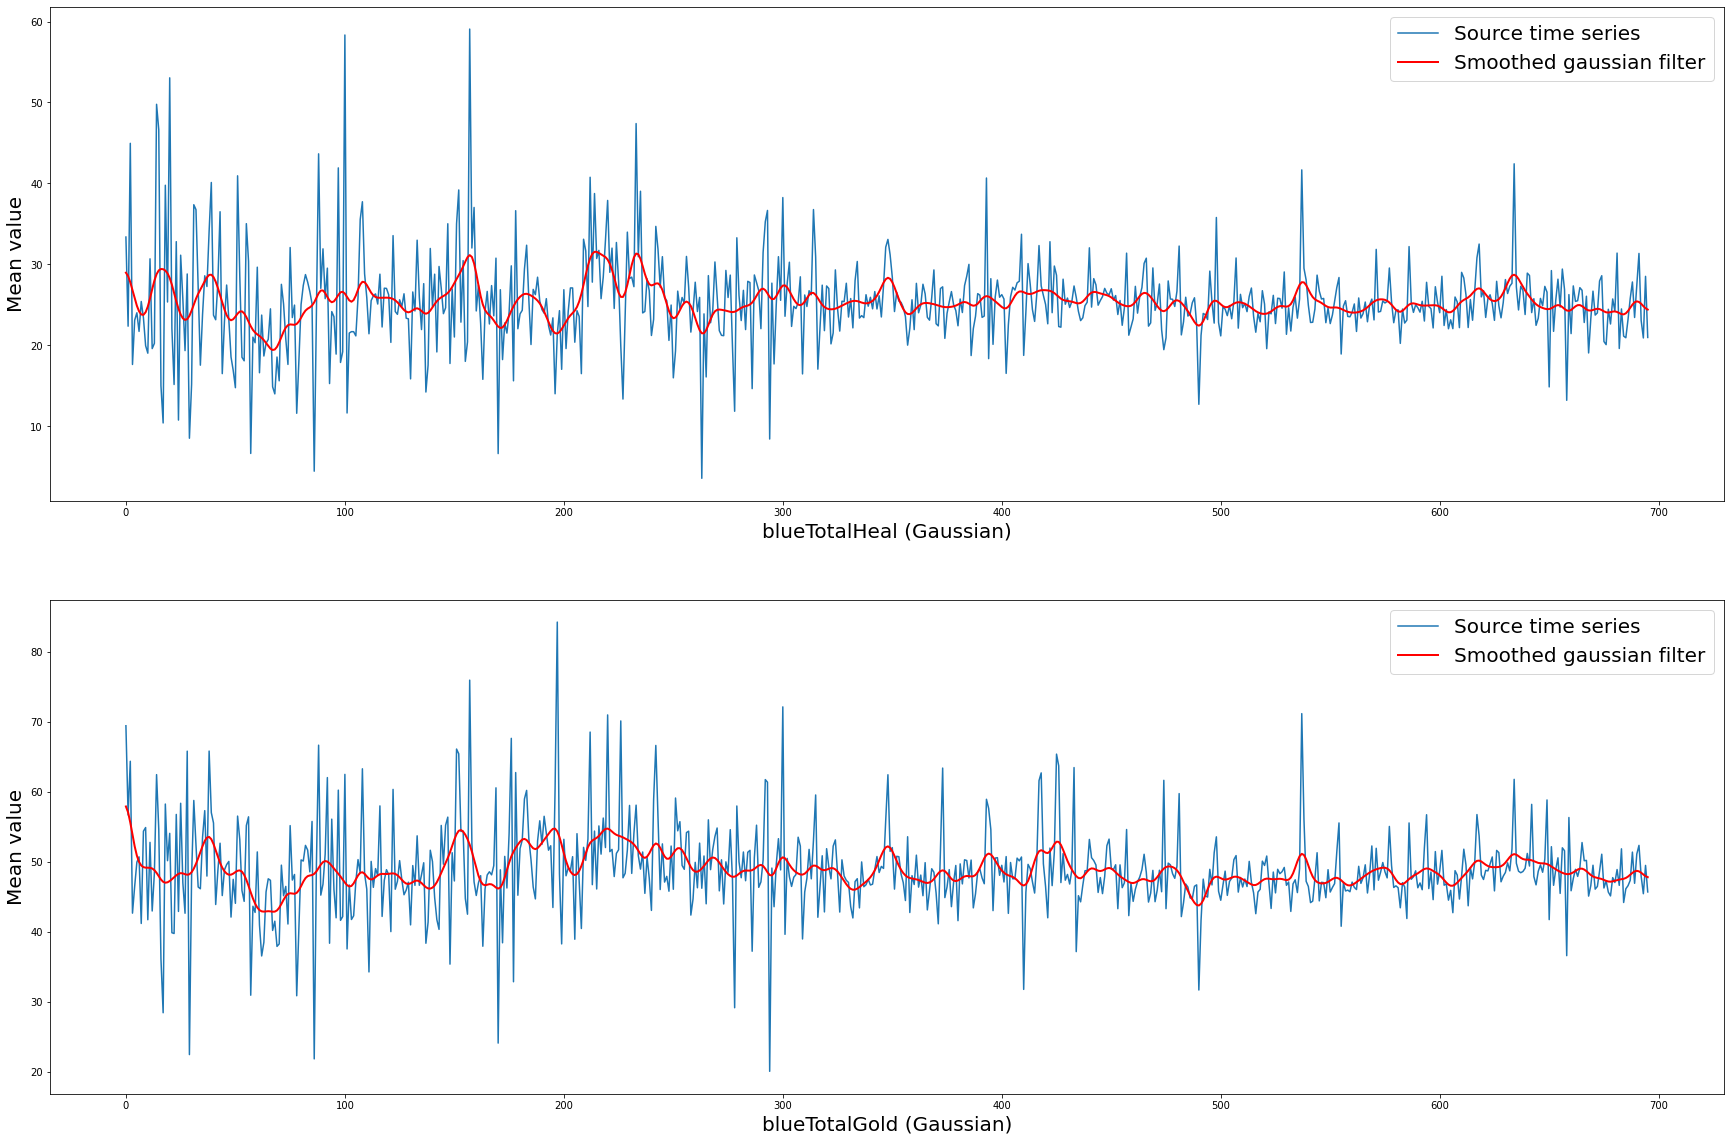

In [11]:
# Gaussian filter

gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 3}

# Prepare data for spectral analisys
gaus_filt_targs = []
pure_targs = []

fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0

for col_name in target_cols:
    smoothed_gaussian = node_fit_predict(gaussian_node, input_data_list[idx])
    gaus_filt_targs.append(smoothed_gaussian.predict)
    pure_targs.append(input_data_list[idx].target)
    axes[idx].plot(input_data_list[idx].idx, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
    axes[idx].set_xlabel(col_name+" (Gaussian)", fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)
    axes[idx].legend(fontsize=20)
    idx += 1

## Exercise 5

Estimate spectral density function for with and without filtering

C:\Users\vando\AppData\Local\Temp/ipykernel_29648/737511901.py:5: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  bartlett = signal.hanning(M=window_size)


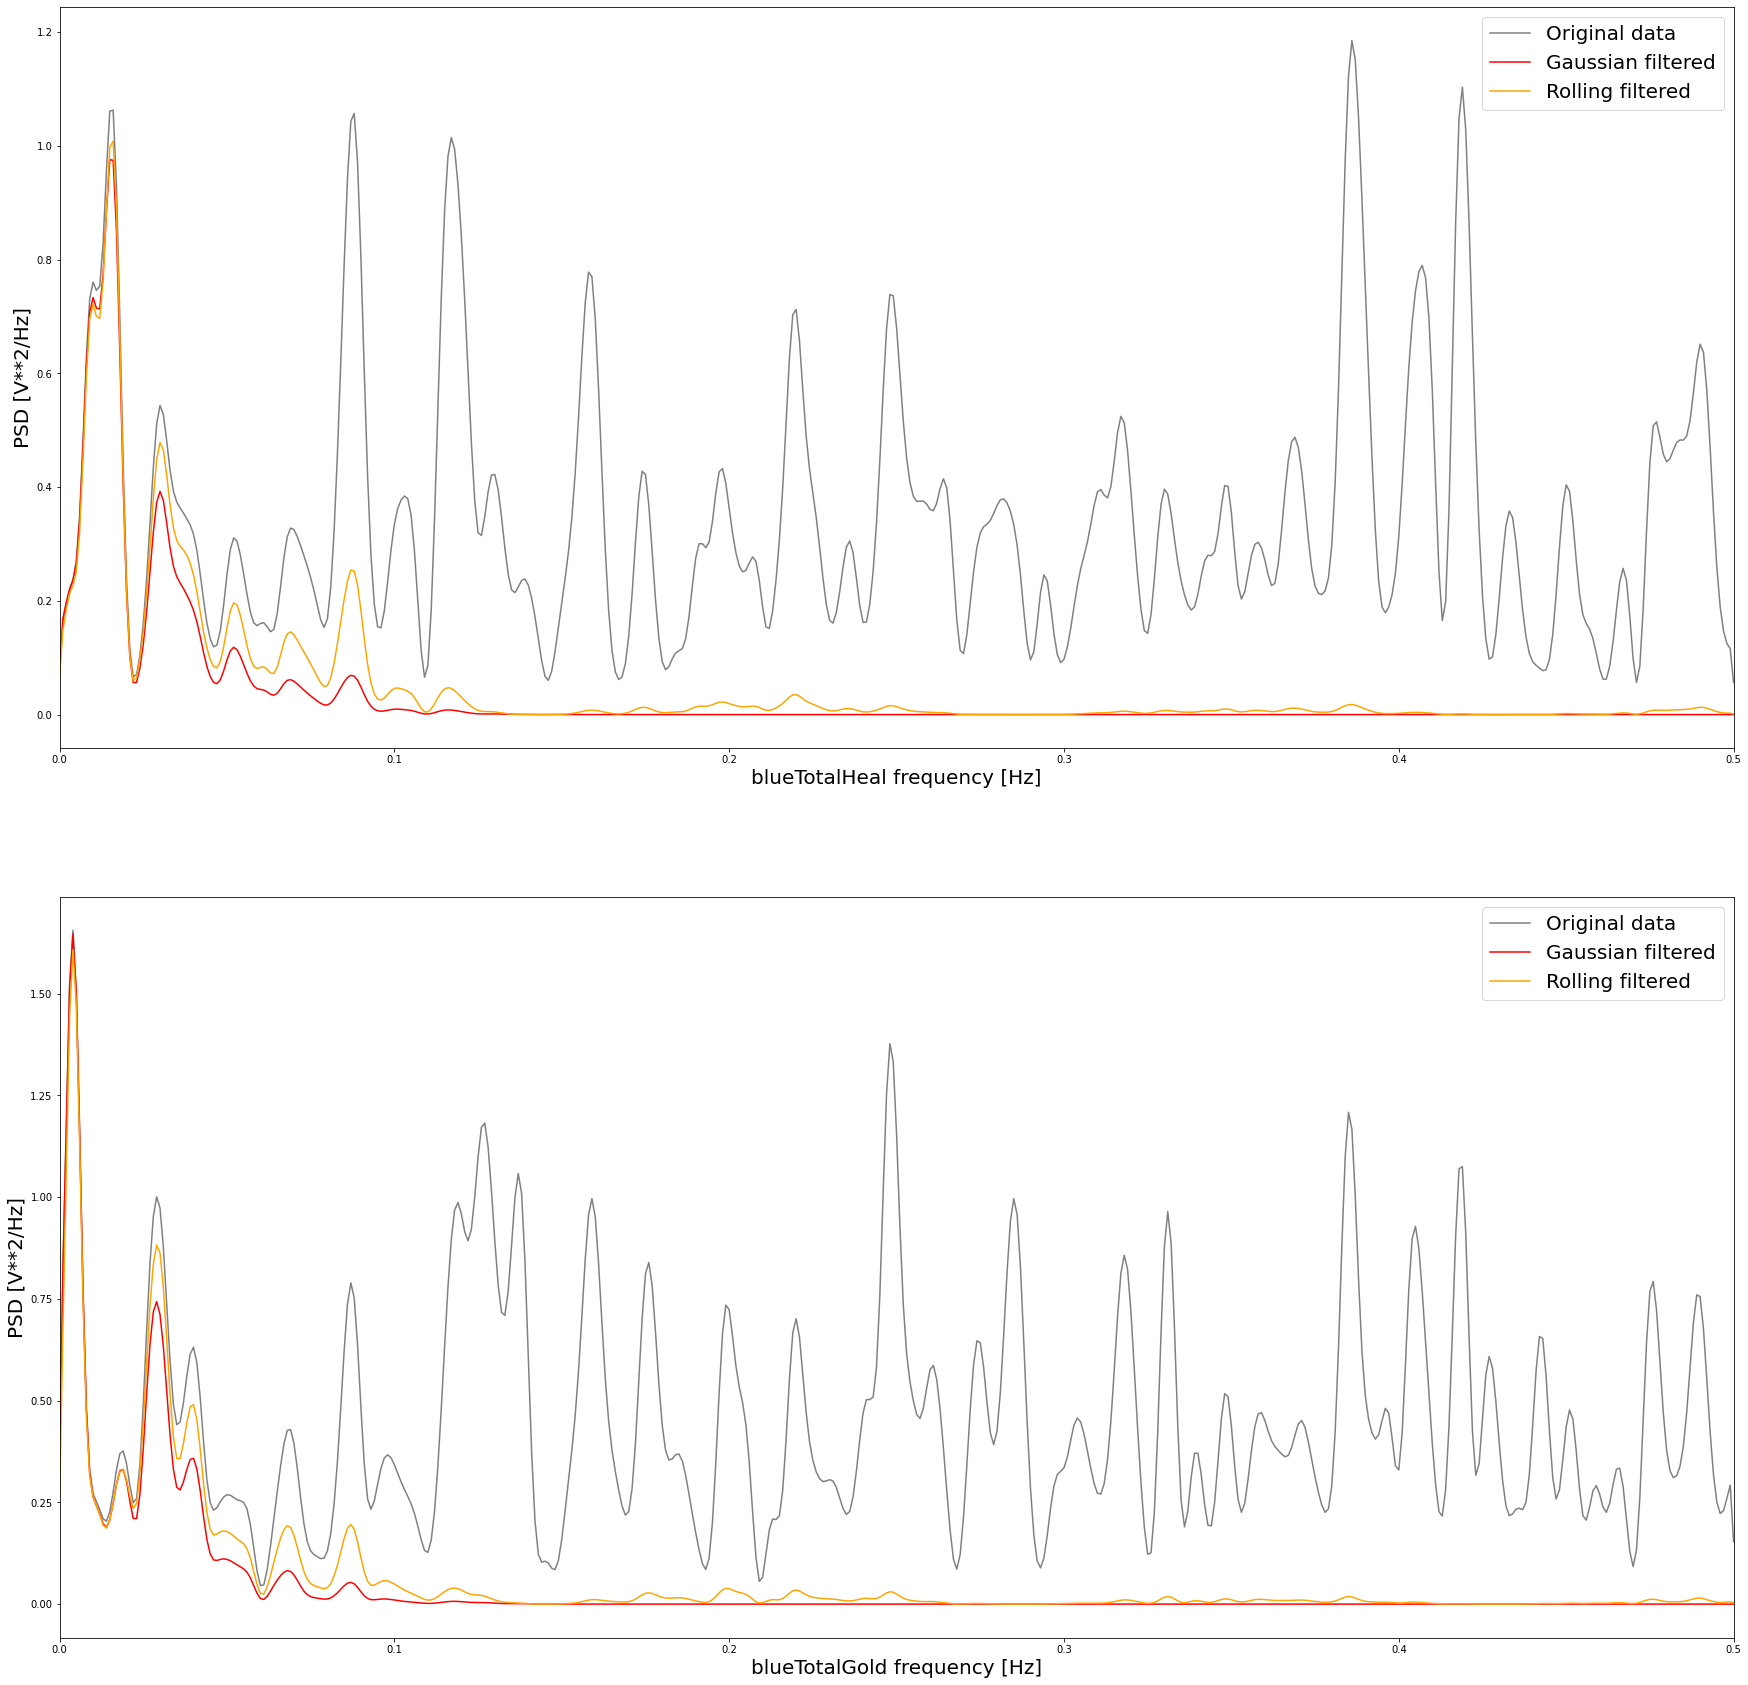

In [12]:
# Plot spectrum for pure and filtered data (As a result high freqs are filtered. Nice Job)

window_size = 72
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

col_idx = 0

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    f, Pxx_den = signal.welch(pure_targs[col_idx], fs=1, scaling='spectrum', nfft = 1000) # Spectrum for orig data
    f_flt_g, Pxx_flt_g = signal.welch(gaus_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_r, Pxx_flt_r = signal.welch(roll_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')

    axes[col_idx].plot(f, Pxx_den, color="grey", label='Original data')
    axes[col_idx].plot(f_flt_g, Pxx_flt_g, color="red", label='Gaussian filtered')
    axes[col_idx].plot(f_flt_r, Pxx_flt_r, color="orange", label='Rolling filtered')

    axes[col_idx].set_xlabel(col_name+' frequency [Hz]', fontsize = 20)
    axes[col_idx].set_ylabel(u'PSD [V**2/Hz]', fontsize = 20)
    axes[col_idx].set_xlim((0,0.5))
    axes[col_idx].legend(fontsize = 20)
    col_idx += 1


## Exercise №6

Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model

In [13]:
# Prepare data for FEDOT

orig_input_data_list = []
orig_train = []
orig_test = []
filter_input_data_list = []
filter_train = []
filter_test = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=40))

# Prepare original data
for col_idx in range(len(target_cols)):
    time_series = pure_targs[col_idx] 
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    orig_input_data_list.append(input_data)
    orig_train.append(train)
    orig_test.append(test)

# Prepare filtered data
for col_idx in range(len(target_cols)):
    time_series = gaus_filt_targs[col_idx]
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    filter_input_data_list.append(input_data)
    filter_train.append(train)
    filter_test.append(test)



Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 500/500 [00:55<00:00,  8.94trial/s, best loss: 2.151733714069226]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 2.152 equal or smaller than initial (+ 5% deviation) 2.286
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 56.13086675398791, 'lag_2': 57.50272576957995}
Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 500/500 [00:56<00:00,  8.85trial/s, best loss: 2.8967604132273106]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 2.897 equal or smaller than initial (+ 5% deviation) 3.180
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to Fa

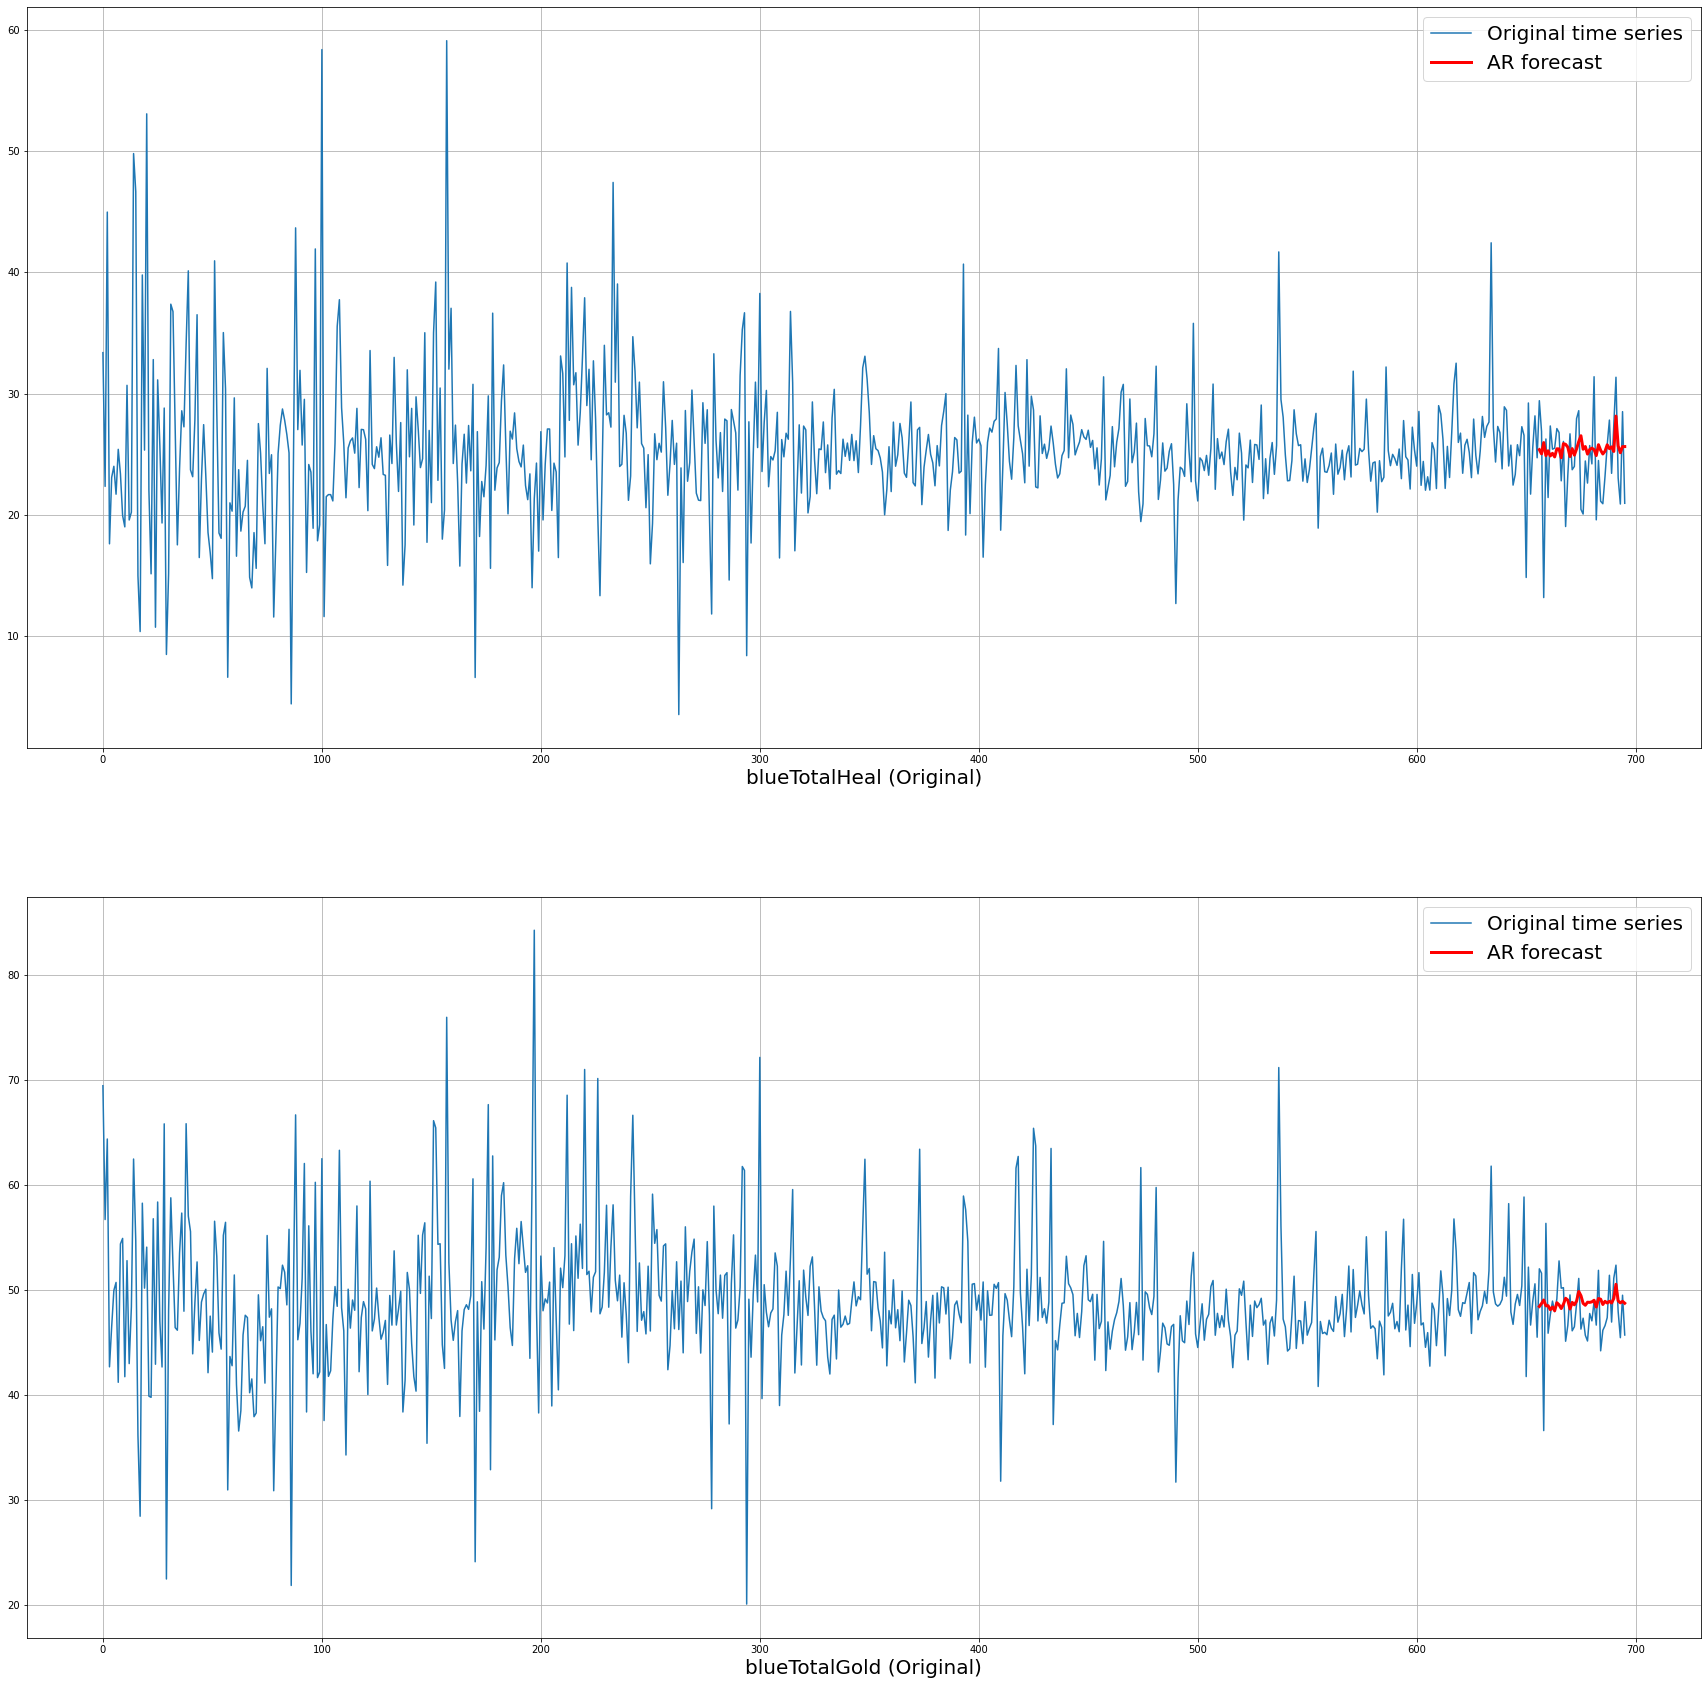

In [14]:
# AR model for original (non-filtered) data

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=orig_train[col_idx],
                                            iterations=500, timeout=5,
                                            cv_folds=3, validation_blocks=2)

    fitted_vals = pipeline.fit(orig_train[col_idx])
    forecast = pipeline.predict(orig_test[col_idx])

    axes[col_idx].plot(orig_input_data_list[col_idx].idx, orig_input_data_list[col_idx].target, label='Original time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Original)', fontsize = 20)
    col_idx += 1

    pipeline.print_structure()

Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 500/500 [00:56<00:00,  8.85trial/s, best loss: 0.7626283688875226]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 0.763 equal or smaller than initial (+ 5% deviation) 0.889
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 2.858403212205775, 'lag_2': 43.34387223378888}
Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 500/500 [00:56<00:00,  8.89trial/s, best loss: 1.1582772118998421]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 1.158 equal or smaller than initial (+ 5% deviation) 1.490
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to F

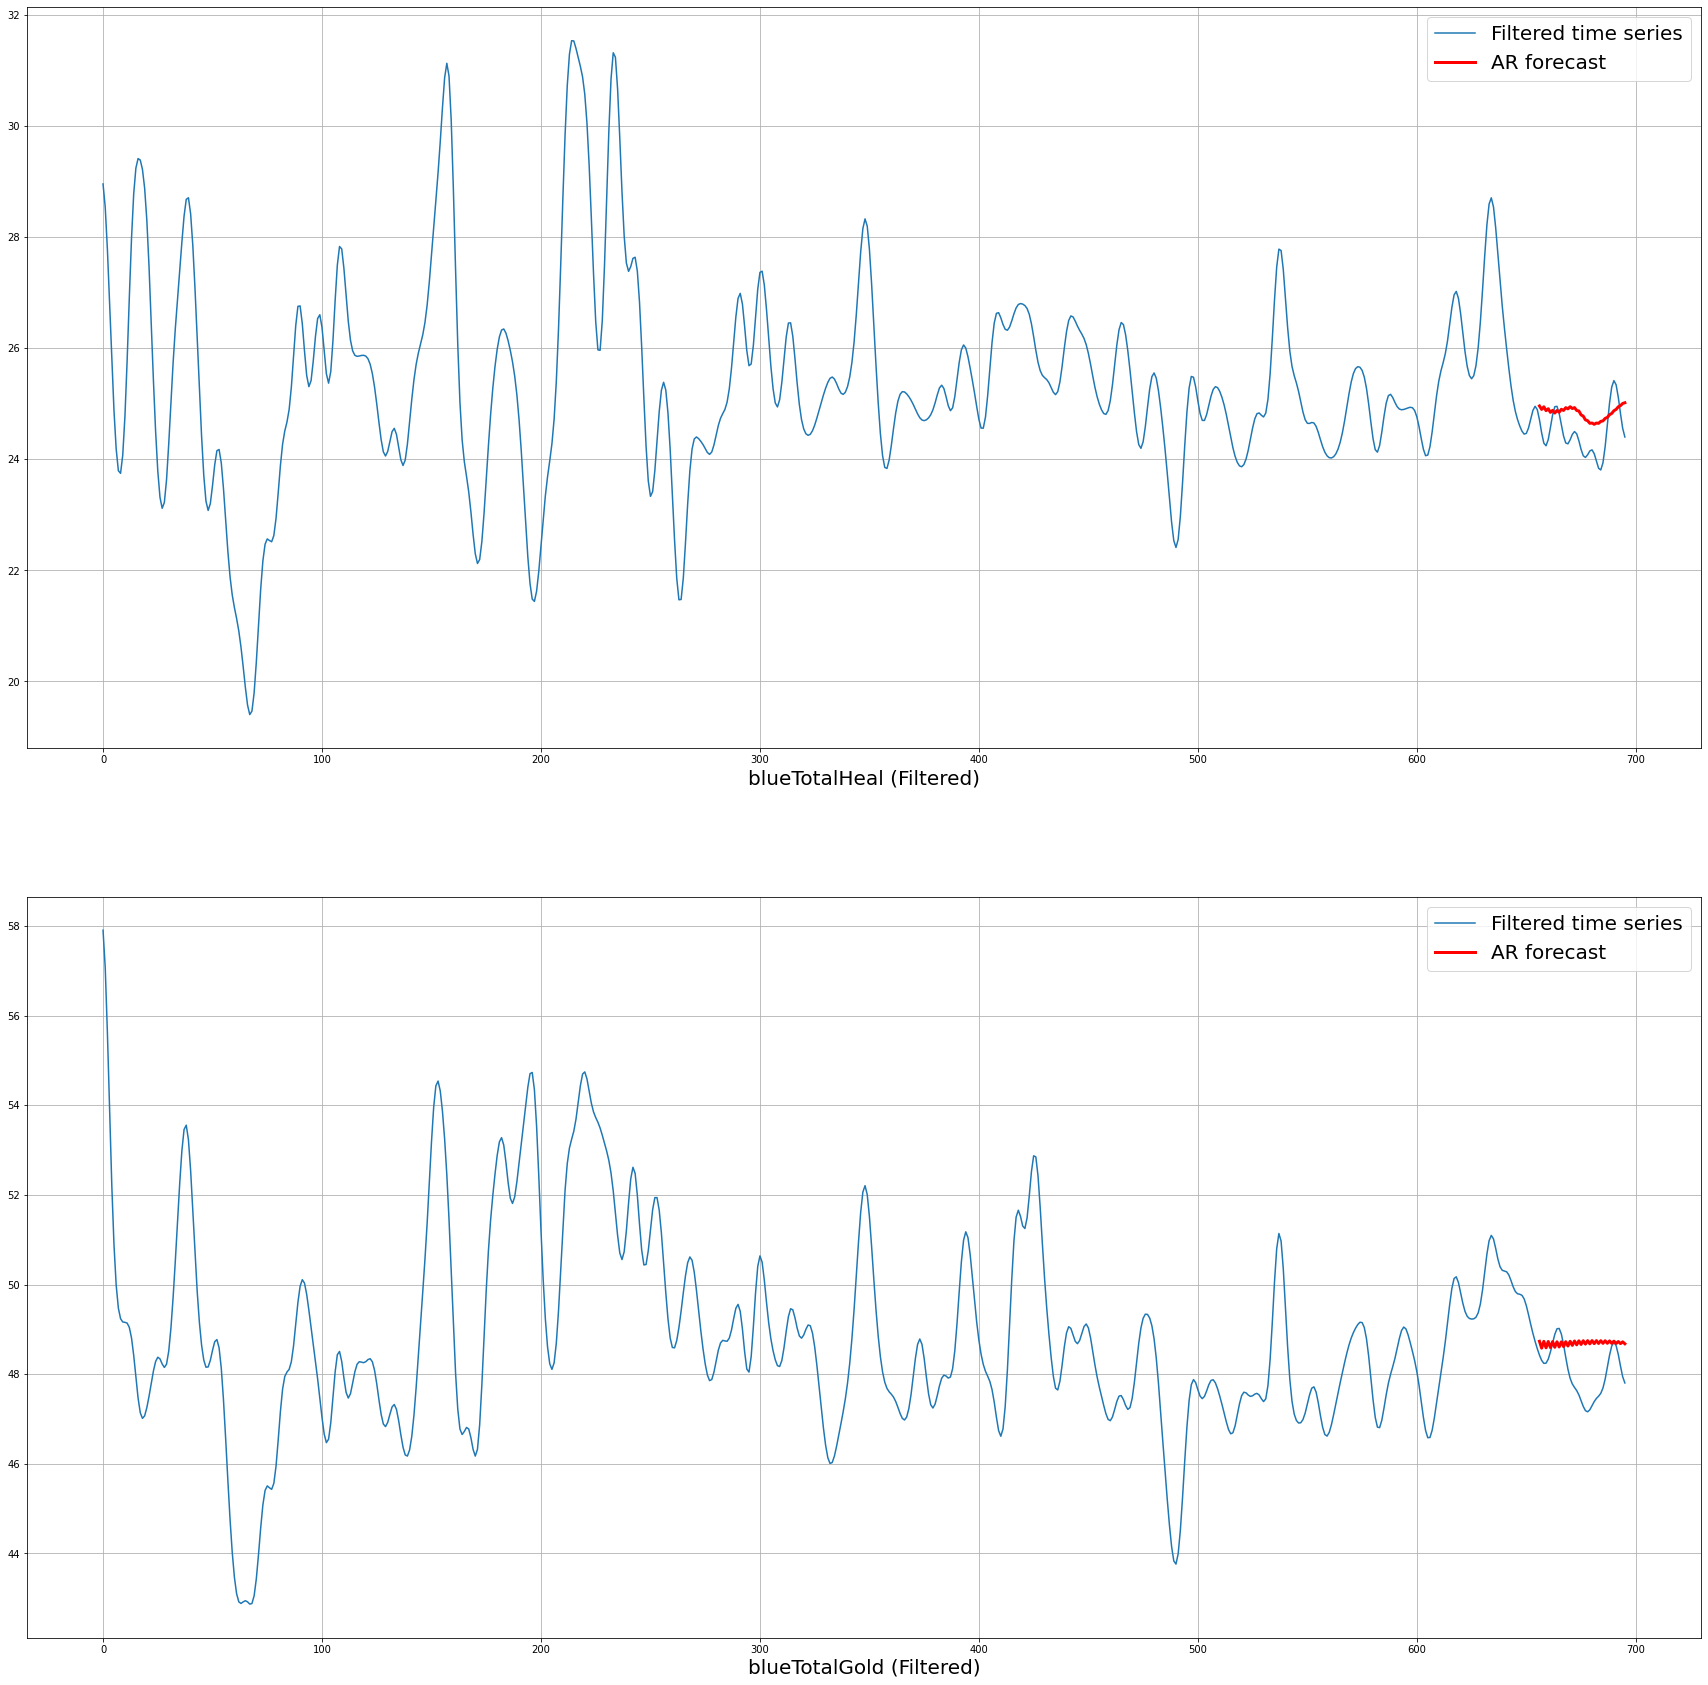

In [16]:
# AR model for filtered data

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=filter_train[col_idx],
                                            iterations=500, timeout=5,
                                            cv_folds=3, validation_blocks=2)

    fitted_vals = pipeline.fit(filter_train[col_idx])
    forecast = pipeline.predict(filter_test[col_idx])

    axes[col_idx].plot(filter_input_data_list[col_idx].idx, filter_input_data_list[col_idx].target, label='Filtered time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Filtered)', fontsize = 20)
    col_idx += 1

    pipeline.print_structure()

In [32]:
# SARIMA model

best_model_orig_list = [] # Models for non filtered data

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))


for col_idx in range(len(target_cols)):

    results = []
    best_aic = float("inf")

    for param in parameters_list:
        
        #try except for the case of wrong parameters
        try:
            model=sm.tsa.statespace.SARIMAX(pure_targs[col_idx], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            
        #print wrong parameters and go on
        # AIC criteria: 
        except ValueError:
                continue
        aic = model.aic

        # save best model, aic, parameters
        if (aic < best_aic):
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    print("------------------------", target_cols[col_idx], "non-filtered model-------------------------")

    print(f'AIC value: {model.aic}')

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())

    print(best_model.summary())

    best_model_orig_list.append(best_model)

    print("----------------------------------------------------------------------------------------------")

Models to analyse by AIC: 72
------------------------ blueTotalHeal non-filtered model-------------------------
AIC value: 4499.036256127935
      parameters          aic
71  (5, 5, 1, 0)  4499.036256
59  (4, 5, 1, 0)  4504.871314
55  (4, 3, 1, 0)  4514.303264
47  (3, 5, 1, 0)  4516.173711
31  (2, 3, 1, 0)  4516.527726
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  696
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood               -2237.518
Date:                             Wed, 01 Dec 2021   AIC                           4499.036
Time:                                     22:04:09   BIC                           4553.354
Sample:                                          0   HQIC                          4520.057
                                             - 696                                         
Covariance Type:                   

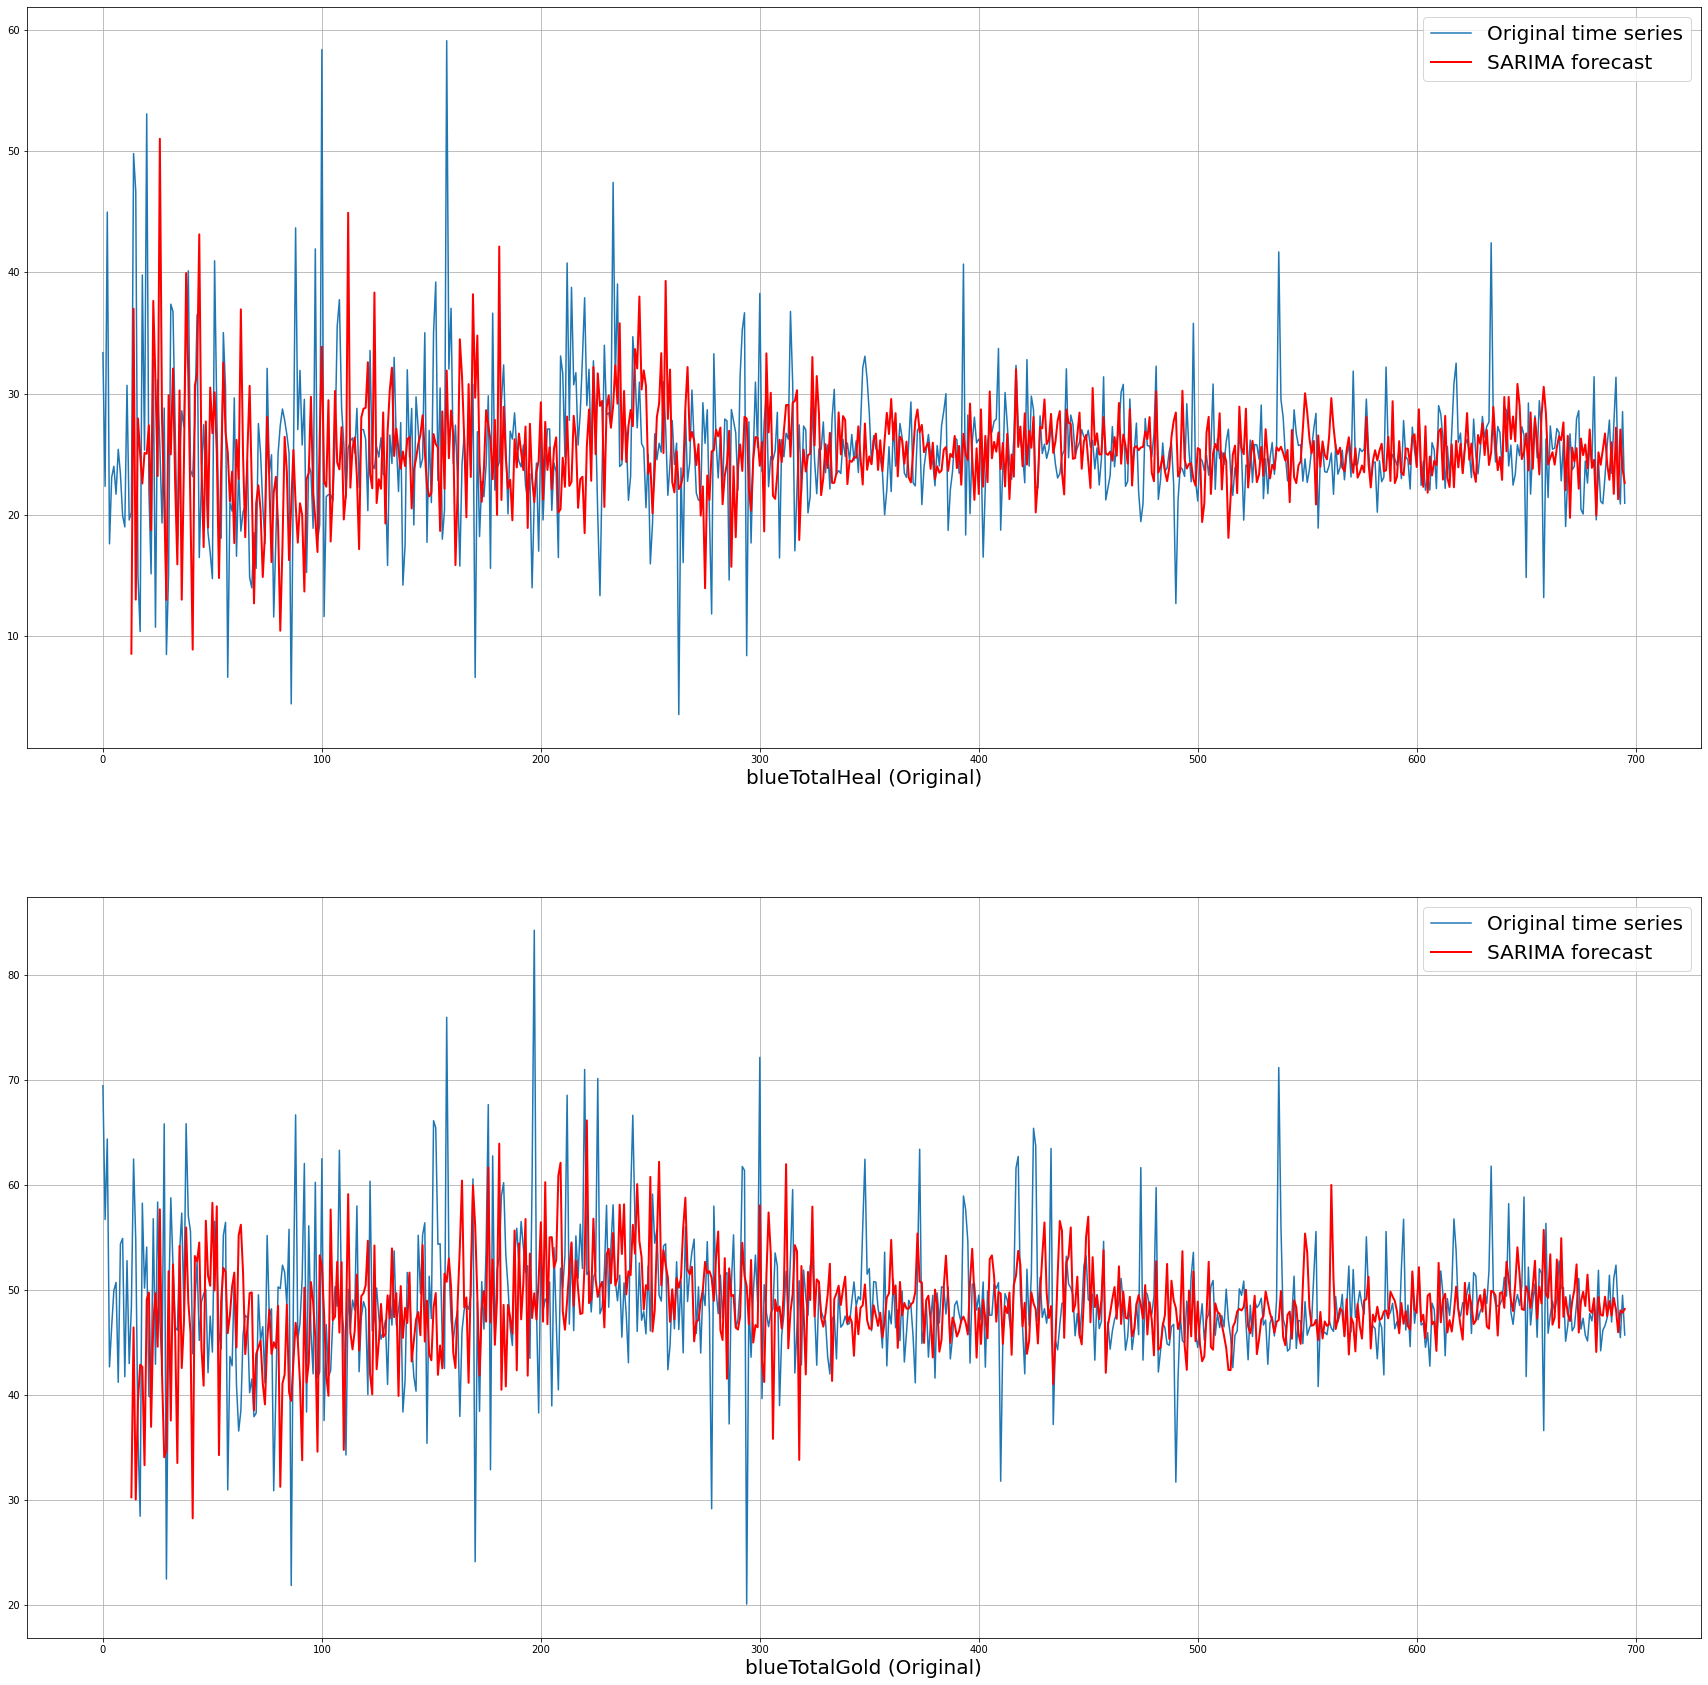

In [36]:
# Visualise and compare

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:


    axes[col_idx].plot(orig_input_data_list[col_idx].idx, orig_input_data_list[col_idx].target, label='Original time series')
    axes[col_idx].plot(orig_input_data_list[col_idx].idx[13:],best_model_orig_list[col_idx].fittedvalues[13:], label='SARIMA forecast', c='red', linewidth=2)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name +' (Original)', fontsize = 20)
    col_idx += 1

51 51
51 51


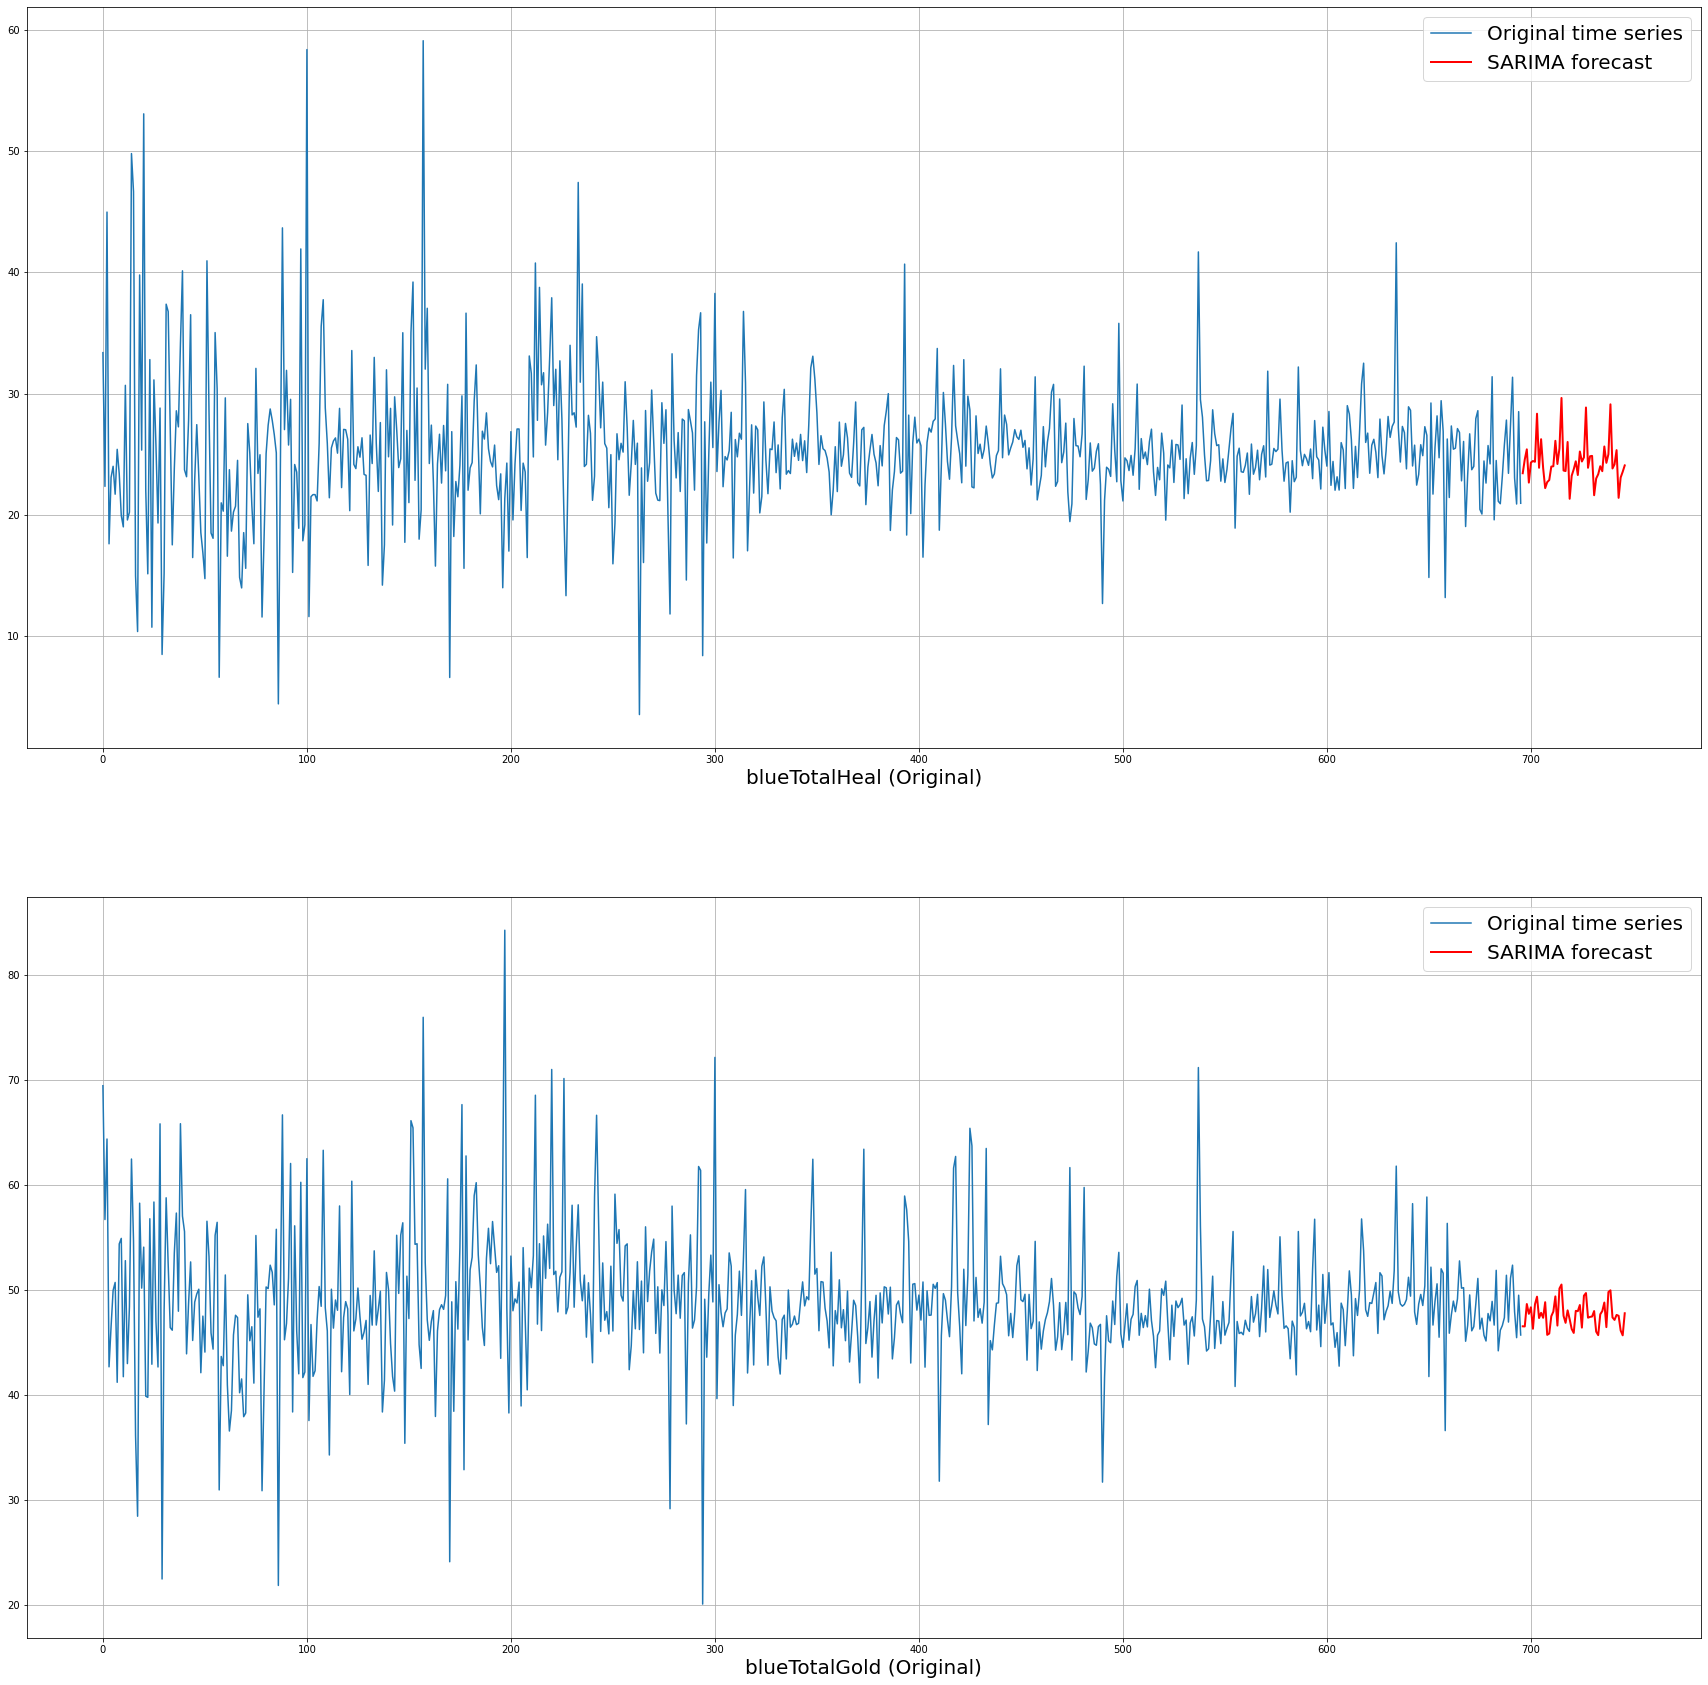

In [44]:
# make forecasting

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    x_data = orig_input_data_list[col_idx].idx
    y_data = orig_input_data_list[col_idx].target

    y_forecast = best_model_orig_list[col_idx].predict(start=len(x_data), end=len(x_data) + 50)
    x_forecast = np.arange(start = len(x_data), stop = len(x_data) + 51)

    print(len(x_forecast), len(y_forecast))

    axes[col_idx].plot(x_data, y_data, label='Original time series')
    axes[col_idx].plot(x_forecast, y_forecast, label='SARIMA forecast', c='red', linewidth=2)

    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name +' (Original)', fontsize = 20)
    col_idx += 1

In [45]:
# SARIMA model

best_model_orig_list = [] # Models for non filtered data

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))



for col_idx in range(len(target_cols)):

    results = []
    best_aic = float("inf")

    for param in parameters_list:
        
        #try except for the case of wrong parameters
        try:
            model=sm.tsa.statespace.SARIMAX(gaus_filt_targs[col_idx], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
            
        #print wrong parameters and go on
        # AIC criteria: 
        except ValueError:
                continue
        aic = model.aic

        # save best model, aic, parameters
        if (aic < best_aic):
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    print("--------------------------", target_cols[col_idx], "filtered model--------------------------")

    print(f'AIC value: {model.aic}')

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())

    print(best_model.summary())

    best_model_orig_list.append(best_model)

    print("----------------------------------------------------------------------------------------------")

Models to analyse by AIC: 72
------------------------ blueTotalHeal non-filtered model-------------------------
AIC value: -4058.019632308942
      parameters          aic
57  (4, 4, 1, 0) -5301.981830
56  (4, 4, 0, 0) -5288.665966
59  (4, 5, 1, 0) -5228.325824
67  (5, 3, 1, 0) -5208.596615
66  (5, 3, 0, 0) -5176.377059
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  696
Model:             SARIMAX(4, 1, 4)x(1, 1, [], 12)   Log Likelihood                2660.991
Date:                             Wed, 01 Dec 2021   AIC                          -5301.982
Time:                                     22:19:55   BIC                          -5256.717
Sample:                                          0   HQIC                         -5284.464
                                             - 696                                         
Covariance Type:                  

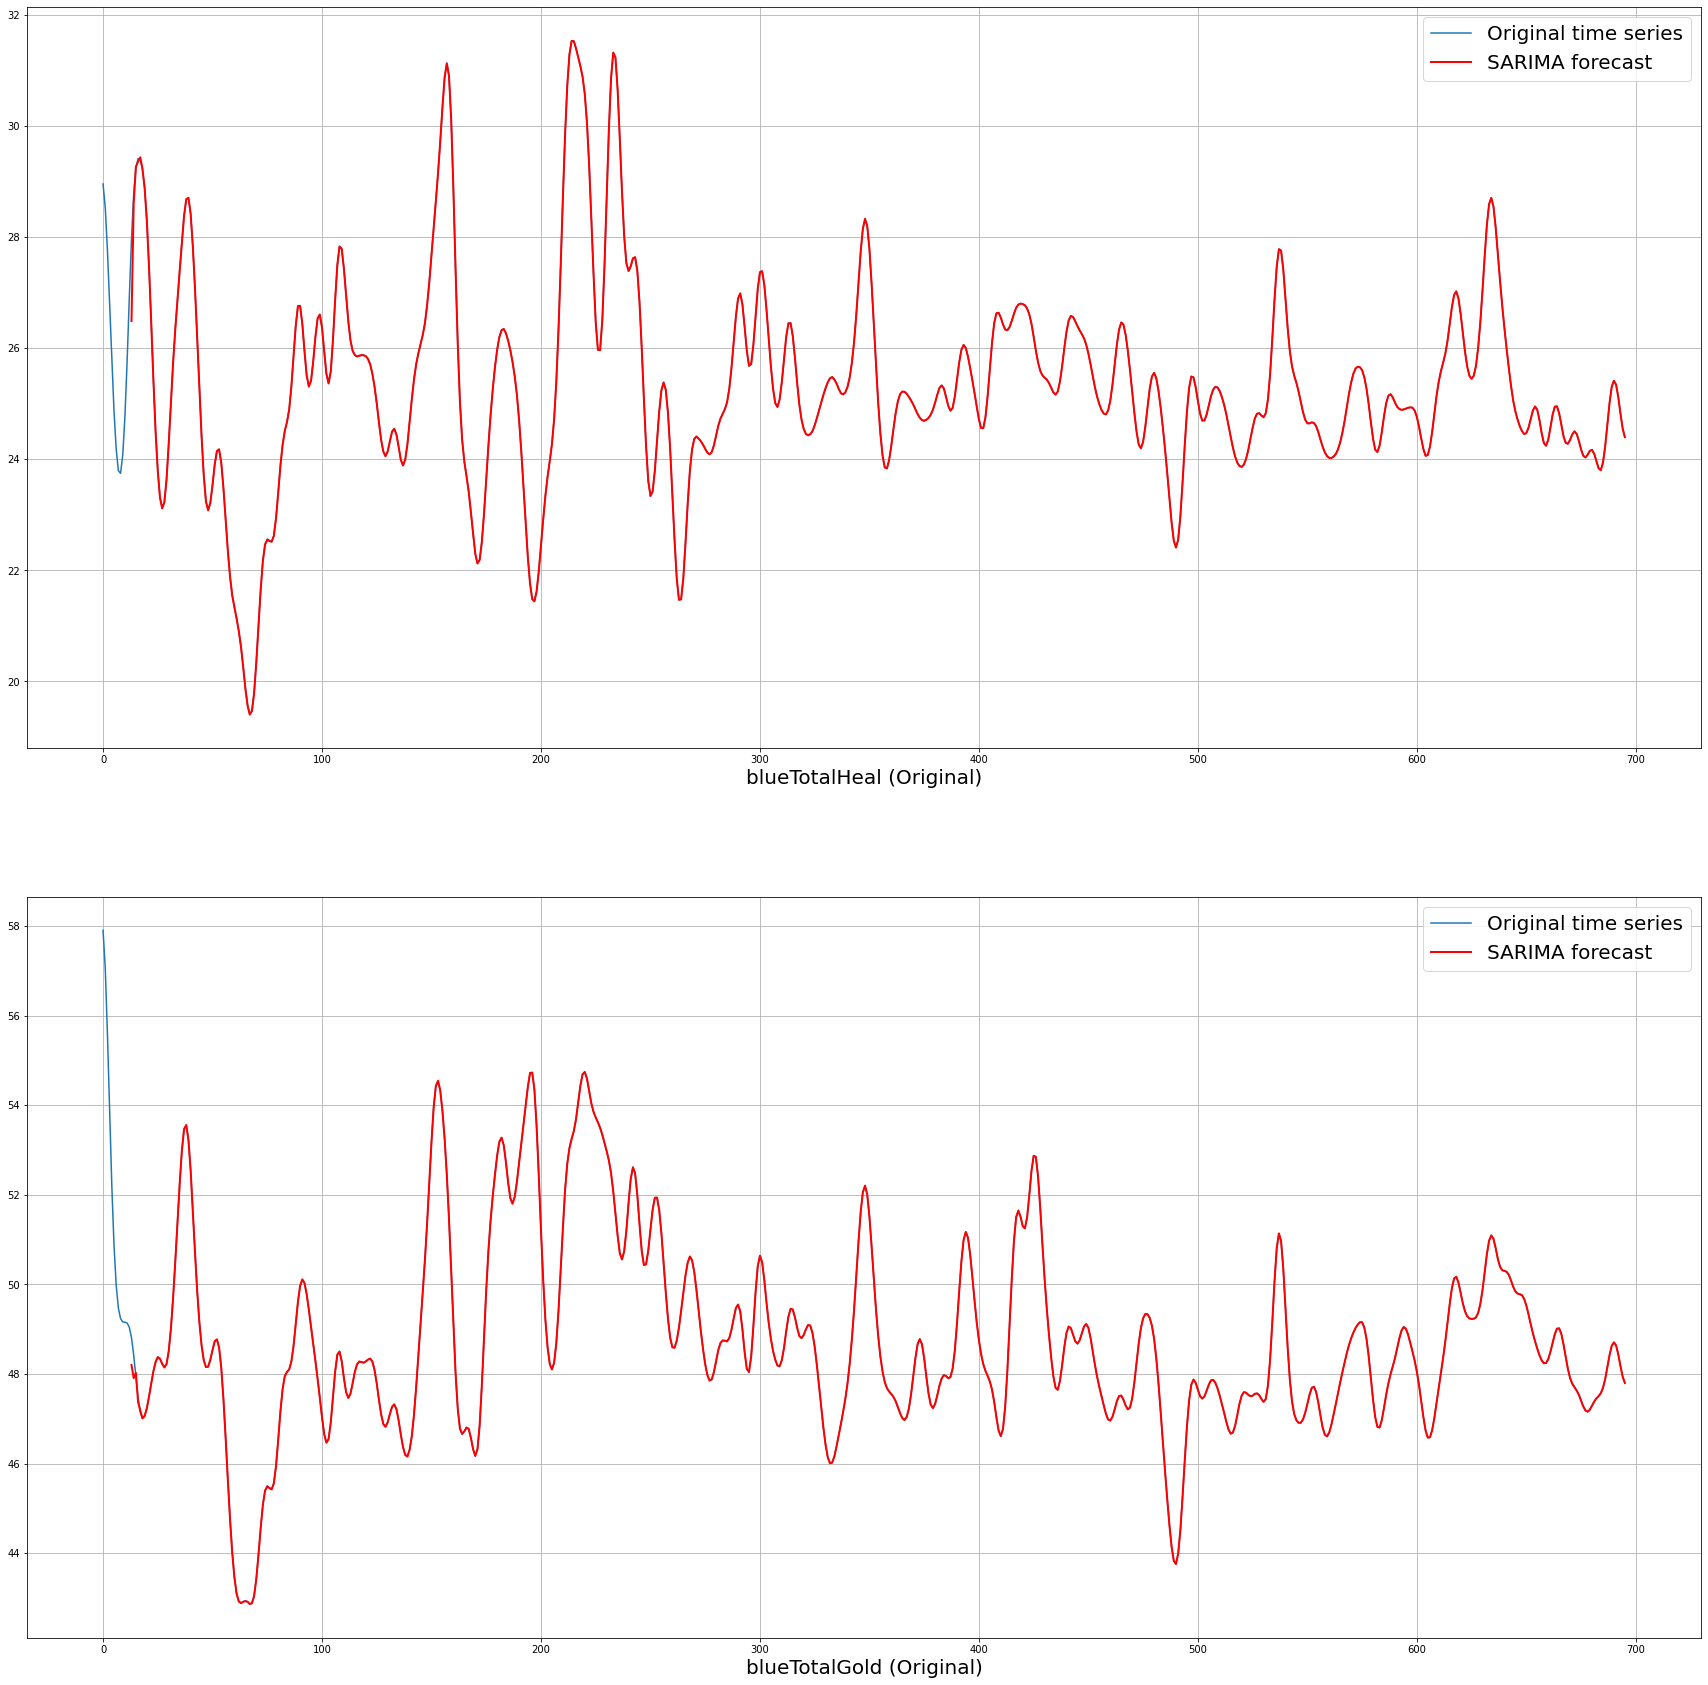

In [46]:
# Visualise and compare

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:


    axes[col_idx].plot(filter_input_data_list[col_idx].idx, filter_input_data_list[col_idx].target, label='Original time series')
    axes[col_idx].plot(filter_input_data_list[col_idx].idx[13:],best_model_orig_list[col_idx].fittedvalues[13:], label='SARIMA forecast', c='red', linewidth=2)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name +' (Original)', fontsize = 20)
    col_idx += 1

51 51
51 51


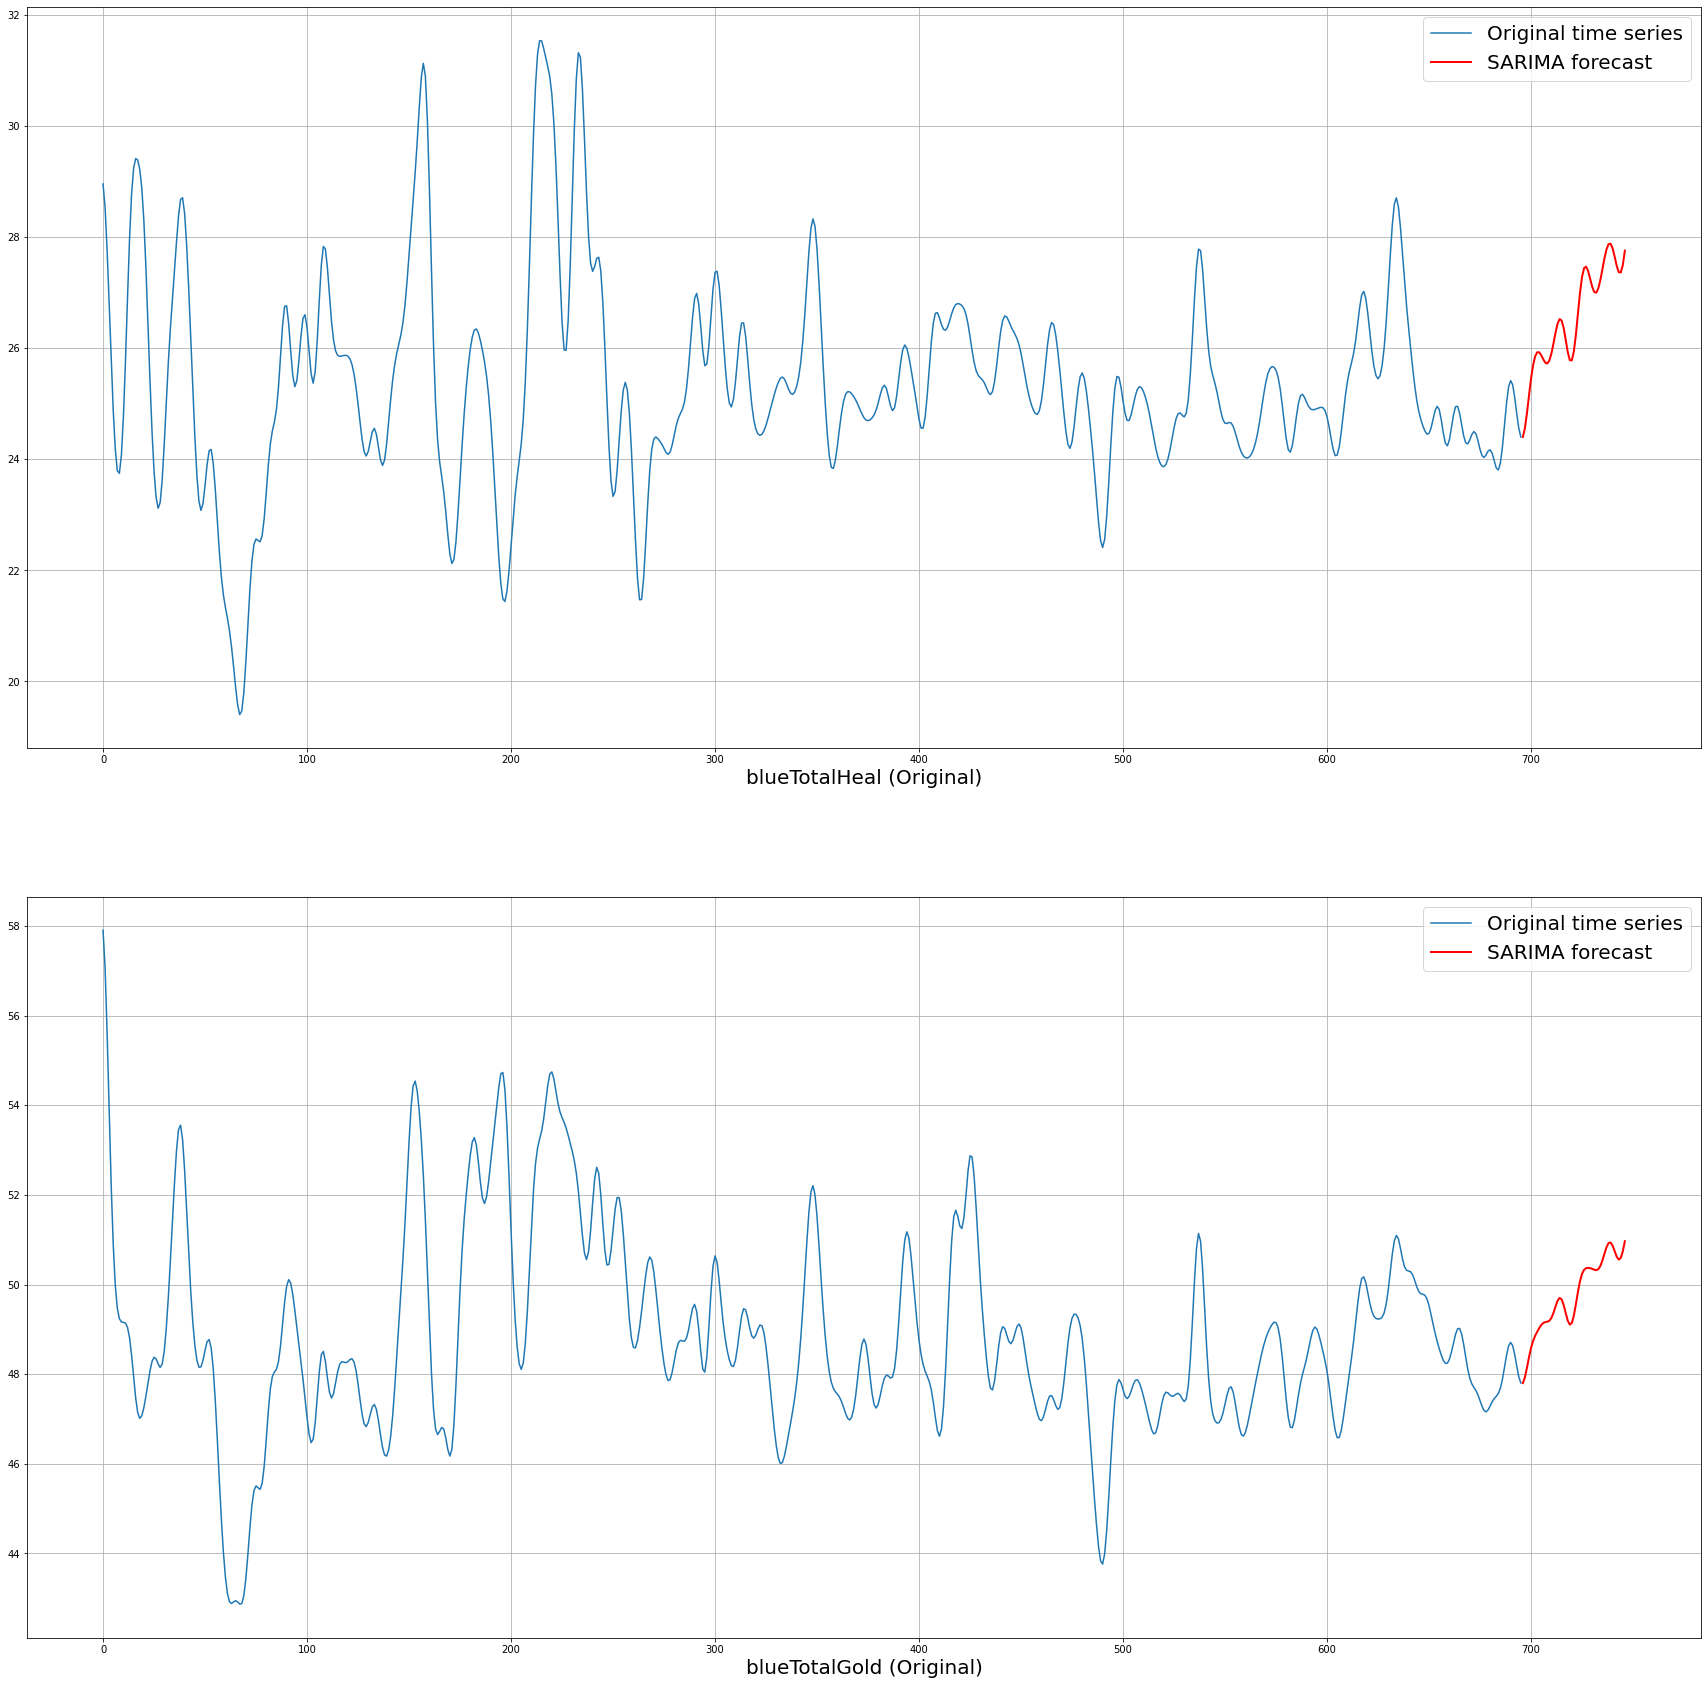

In [47]:
# make forecasting

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    x_data = filter_input_data_list[col_idx].idx
    y_data = filter_input_data_list[col_idx].target

    y_forecast = best_model_orig_list[col_idx].predict(start=len(x_data), end=len(x_data) + 50)
    x_forecast = np.arange(start = len(x_data), stop = len(x_data) + 51)

    print(len(x_forecast), len(y_forecast))

    axes[col_idx].plot(x_data, y_data, label='Original time series')
    axes[col_idx].plot(x_forecast, y_forecast, label='SARIMA forecast', c='red', linewidth=2)

    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name +' (Original)', fontsize = 20)
    col_idx += 1